# Initialization

In [1]:
#
##
# load in necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import NullFormatter, MultipleLocator


#
##
# settings
plt.rcParams['font.family'] = 'Times New Roman'
labelsize = 14

In [208]:
#
##
# load in data
#

master = pd.read_csv("../Data/Master File.csv")
master['HAI'] = pd.to_numeric(master['HAI'], errors='coerce')
master['Fold-change'] = pd.to_numeric(master['Fold-change'], errors='coerce')
master_uga2022_filepath = r"G:\Shared drives\Einav Lab\Research\Aaron Lane\2024LongitudinalDynamics\Code\UGA 2022 Master File.csv"
# master_uga2022_filepath='./UGA 2022 Master File.csv'
vac_hist = pd.read_csv("../Data/Vaccination History.csv")
try:
    master_uga2022 = pd.read_csv(master_uga2022_filepath)
    master_uga2022['HAI'] = pd.to_numeric(master_uga2022['HAI'], errors='coerce')
    master_uga2022['Fold-change'] = pd.to_numeric(master_uga2022['Fold-change'], errors='coerce')
except:
    print("2022 UGA not loaded because it is not yet publically available.")


In [209]:
#
##
# add proxy day column 
#

def get_proxies(df):
    df = df.copy()
    df['Proxy Day'] = np.nan  
    
    group_cols = ['Subject', 'Virus']
    
    # --- Day0 ---
    is_day0 = df['Day'] == 0
    df.loc[is_day0, 'Proxy Day'] = 'Day0'
    
    # --- Day28p ---
    window28 = df[(df['Day'] >= 13) & (df['Day'] <= 60)].copy()
    window28['abs_diff'] = (window28['Day'] - 28).abs()
    idx_28 = window28.groupby(group_cols)['abs_diff'].idxmin()
    df.loc[idx_28, 'Proxy Day'] = 'Day28p'
    
    # --- Day90p ---
    window90 = df[(df['Day'] >= 61) & (df['Day'] <= 120)].copy()
    window90['abs_diff'] = (window90['Day'] - 90).abs()
    idx_90 = window90.groupby(group_cols)['abs_diff'].idxmin()
    df.loc[idx_90, 'Proxy Day'] = 'Day90p'
    
    # --- Day365p ---
    window365 = df[df['Day'] >= 180].copy()
    window365['abs_diff'] = (window365['Day'] - 365).abs()
    idx_365 = window365.groupby(group_cols)['abs_diff'].idxmin()
    df.loc[idx_365, 'Proxy Day'] = 'Day365p'
    
    return df

master = get_proxies(master)
try:
    _=master_uga2022
    master_uga2022 = get_proxies(master_uga2022)
except:
    print("2022 UGA not loaded because it is not yet publically available.")

# # get rid of Viruses without Day0, Day28p, and Day365p
# master = 


C:\Users\alane\AppData\Local\Temp\ipykernel_20380\696245961.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Day0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[is_day0, 'Proxy Day'] = 'Day0'
C:\Users\alane\AppData\Local\Temp\ipykernel_20380\696245961.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Day0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[is_day0, 'Proxy Day'] = 'Day0'


# Phenotype Classification

In [205]:
strong_threshold = 4

valid_master = master.groupby(['Virus', 'Subject']).filter(lambda x: set(['Day0', 'Day28p', 'Day365p']).issubset(x['Proxy Day'].unique())).reset_index(drop=True)

# Step 2: Find subjects that pass all the validation checks from loop-based code
valid_subjects = []

for subject in valid_master['Subject'].unique():
    subject_data = valid_master[valid_master['Subject'] == subject]
    
    # Check if has both Day28p and Day365p data
    if not ('Day28p' in subject_data['Proxy Day'].values and 'Day365p' in subject_data['Proxy Day'].values):
        continue
    
    # Get vaccine strain for this subject
    vac_strain = subject_data['Vaccine Strain'].iloc[0]  # Assuming consistent per subject
    
    # Check vaccine strain has both timepoints and no missing values
    vac_day28 = subject_data[(subject_data['Virus'] == vac_strain) & 
                            (subject_data['Proxy Day'] == 'Day28p')]
    vac_day365 = subject_data[(subject_data['Virus'] == vac_strain) & 
                             (subject_data['Proxy Day'] == 'Day365p')]
    
    if (vac_day28.empty or vac_day365.empty or 
        pd.isna(vac_day28['Fold-change'].values[0]) or 
        pd.isna(vac_day365['Fold-change'].values[0])):
        continue
    
    # Check at least one non-vaccine virus has both timepoints
    non_vac_variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
    has_valid_variant = False
    
    for variant in non_vac_variants:
        var_day28 = subject_data[(subject_data['Virus'] == variant) & 
                                (subject_data['Proxy Day'] == 'Day28p')]
        var_day365 = subject_data[(subject_data['Virus'] == variant) & 
                                 (subject_data['Proxy Day'] == 'Day365p')]
        
        if (not var_day28.empty and not var_day365.empty and
            not pd.isna(var_day28['Fold-change'].values[0]) and
            not pd.isna(var_day365['Fold-change'].values[0])):
            has_valid_variant = True
            break
    
    if has_valid_variant:
        valid_subjects.append(subject)

valid_subjects = set(valid_subjects)

# Step 3: Now apply the classification logic on valid subjects only
valid_master_filtered = valid_master[valid_master['Subject'].isin(valid_subjects)]

# Get vaccine responses for valid subjects
vac_day28_strong = set(valid_master_filtered[
    (valid_master_filtered['Proxy Day'] == 'Day28p') &
    (valid_master_filtered['Virus'] == valid_master_filtered['Vaccine Strain']) &
    (valid_master_filtered['Fold-change'] >= strong_threshold)
]['Subject'].unique())

vac_day365_strong = set(valid_master_filtered[
    (valid_master_filtered['Proxy Day'] == 'Day365p') &
    (valid_master_filtered['Virus'] == valid_master_filtered['Vaccine Strain']) &
    (valid_master_filtered['Fold-change'] >= strong_threshold)
]['Subject'].unique())

# Find subjects with ≥1 variant ≥4x at both timepoints (same variant)
durable_variant_subjects = []

for subject in valid_subjects:
    subject_data = valid_master_filtered[valid_master_filtered['Subject'] == subject]
    vac_strain = subject_data['Vaccine Strain'].iloc[0]
    variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
    
    for variant in variants:
        day28_data = subject_data[(subject_data['Virus'] == variant) & 
                                 (subject_data['Proxy Day'] == 'Day28p')]
        day365_data = subject_data[(subject_data['Virus'] == variant) & 
                                  (subject_data['Proxy Day'] == 'Day365p')]
        
        if (not day28_data.empty and not day365_data.empty and
            not pd.isna(day28_data['Fold-change'].values[0]) and
            not pd.isna(day365_data['Fold-change'].values[0]) and
            day28_data['Fold-change'].values[0] >= strong_threshold and
            day365_data['Fold-change'].values[0] >= strong_threshold):
            durable_variant_subjects.append(subject)
            break

durable_variant_subjects = set(durable_variant_subjects)

# Find subjects with ≥1 variant ≥4x at day28 (but variant must have both timepoints available)
variant_day28_strong_with_both_timepoints = []

for subject in valid_subjects:
    subject_data = valid_master_filtered[valid_master_filtered['Subject'] == subject]
    vac_strain = subject_data['Vaccine Strain'].iloc[0]
    variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
    
    for variant in variants:
        day28_data = subject_data[(subject_data['Virus'] == variant) & 
                                 (subject_data['Proxy Day'] == 'Day28p')]
        day365_data = subject_data[(subject_data['Virus'] == variant) & 
                                  (subject_data['Proxy Day'] == 'Day365p')]
        
        # Only consider variants that have both timepoints 
        if (not day28_data.empty and not day365_data.empty and
            not pd.isna(day28_data['Fold-change'].values[0]) and
            not pd.isna(day365_data['Fold-change'].values[0])):
            # But only check day28 condition for transient
            if day28_data['Fold-change'].values[0] >= strong_threshold:
                variant_day28_strong_with_both_timepoints.append(subject)
                break

variant_day28_strong_filtered = set(variant_day28_strong_with_both_timepoints)

# Classification - exact order matching loop-based logic
# First: Durable check (vaccine ≥4x both timepoints AND ≥1 variant ≥4x both timepoints)
durable_candidates = vac_day28_strong.intersection(vac_day365_strong).intersection(durable_variant_subjects)
durable = list(durable_candidates)

# Second: Transient check (vaccine ≥4x day28 AND ≥1 variant ≥4x day28, but variant must have both timepoints) 
# BUT exclude those already classified as durable
transient_candidates = vac_day28_strong.intersection(variant_day28_strong_filtered)
transient = list(transient_candidates.difference(durable_candidates))

# Third: Weak (everything else that passed validation)
weak = list(valid_subjects.difference(durable_candidates).difference(transient_candidates))

print(f"Durable: {len(durable)}")
print(f"Transient: {len(transient)}")
print(f"Weak: {len(weak)}")
print(f"Total: {len(durable) + len(transient) + len(weak)}")
print(f"Valid subjects: {len(valid_subjects)}")

Durable: 210
Transient: 238
Weak: 878
Total: 1326
Valid subjects: 1326


In [206]:
#
##
# if 2022 UGA data is released, classify phenotype
#

try:
    _ = master_uga2022 

    strong_threshold = 4

    valid_master_uga2022 = master_uga2022.groupby(['Virus', 'Subject']).filter(lambda x: set(['Day0', 'Day28p', 'Day365p']).issubset(x['Proxy Day'].unique())).reset_index(drop=True)

    # Step 2: Find subjects that pass all the validation checks from loop-based code
    valid_subjects = []

    for subject in valid_master_uga2022['Subject'].unique():
        subject_data = valid_master_uga2022[valid_master_uga2022['Subject'] == subject]
        
        # Check if has both Day28p and Day365p data
        if not ('Day28p' in subject_data['Proxy Day'].values and 'Day365p' in subject_data['Proxy Day'].values):
            continue
        
        # Get vaccine strain for this subject
        vac_strain = subject_data['Vaccine Strain'].iloc[0]  # Assuming consistent per subject
        
        # Check vaccine strain has both timepoints and no missing values
        vac_day28 = subject_data[(subject_data['Virus'] == vac_strain) & 
                                (subject_data['Proxy Day'] == 'Day28p')]
        vac_day365 = subject_data[(subject_data['Virus'] == vac_strain) & 
                                (subject_data['Proxy Day'] == 'Day365p')]
        
        if (vac_day28.empty or vac_day365.empty or 
            pd.isna(vac_day28['Fold-change'].values[0]) or 
            pd.isna(vac_day365['Fold-change'].values[0])):
            continue
        
        # Check at least one non-vaccine virus has both timepoints
        non_vac_variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
        has_valid_variant = False
        
        for variant in non_vac_variants:
            var_day28 = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day28p')]
            var_day365 = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day365p')]
            
            if (not var_day28.empty and not var_day365.empty and
                not pd.isna(var_day28['Fold-change'].values[0]) and
                not pd.isna(var_day365['Fold-change'].values[0])):
                has_valid_variant = True
                break
        
        if has_valid_variant:
            valid_subjects.append(subject)

    valid_subjects = set(valid_subjects)

    # Step 3: Now apply the classification logic on valid subjects only
    valid_master_filtered = valid_master_uga2022[valid_master_uga2022['Subject'].isin(valid_subjects)]

    # Get vaccine responses for valid subjects
    vac_day28_strong = set(valid_master_filtered[
        (valid_master_filtered['Proxy Day'] == 'Day28p') &
        (valid_master_filtered['Virus'] == valid_master_filtered['Vaccine Strain']) &
        (valid_master_filtered['Fold-change'] >= strong_threshold)
    ]['Subject'].unique())

    vac_day365_strong = set(valid_master_filtered[
        (valid_master_filtered['Proxy Day'] == 'Day365p') &
        (valid_master_filtered['Virus'] == valid_master_filtered['Vaccine Strain']) &
        (valid_master_filtered['Fold-change'] >= strong_threshold)
    ]['Subject'].unique())

    # Find subjects with ≥1 variant ≥4x at both timepoints (same variant)
    durable_variant_subjects = []

    for subject in valid_subjects:
        subject_data = valid_master_filtered[valid_master_filtered['Subject'] == subject]
        vac_strain = subject_data['Vaccine Strain'].iloc[0]
        variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
        
        for variant in variants:
            day28_data = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day28p')]
            day365_data = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day365p')]
            
            if (not day28_data.empty and not day365_data.empty and
                not pd.isna(day28_data['Fold-change'].values[0]) and
                not pd.isna(day365_data['Fold-change'].values[0]) and
                day28_data['Fold-change'].values[0] >= strong_threshold and
                day365_data['Fold-change'].values[0] >= strong_threshold):
                durable_variant_subjects.append(subject)
                break

    durable_variant_subjects = set(durable_variant_subjects)

    # Find subjects with ≥1 variant ≥4x at day28 (but variant must have both timepoints available)
    variant_day28_strong_with_both_timepoints = []

    for subject in valid_subjects:
        subject_data = valid_master_filtered[valid_master_filtered['Subject'] == subject]
        vac_strain = subject_data['Vaccine Strain'].iloc[0]
        variants = subject_data[subject_data['Virus'] != vac_strain]['Virus'].unique()
        
        for variant in variants:
            day28_data = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day28p')]
            day365_data = subject_data[(subject_data['Virus'] == variant) & 
                                    (subject_data['Proxy Day'] == 'Day365p')]
            
            # Only consider variants that have both timepoints 
            if (not day28_data.empty and not day365_data.empty and
                not pd.isna(day28_data['Fold-change'].values[0]) and
                not pd.isna(day365_data['Fold-change'].values[0])):
                # But only check day28 condition for transient
                if day28_data['Fold-change'].values[0] >= strong_threshold:
                    variant_day28_strong_with_both_timepoints.append(subject)
                    break

    variant_day28_strong_filtered = set(variant_day28_strong_with_both_timepoints)

    # Classification - exact order matching loop-based logic
    # First: Durable check (vaccine ≥4x both timepoints AND ≥1 variant ≥4x both timepoints)
    durable_candidates = vac_day28_strong.intersection(vac_day365_strong).intersection(durable_variant_subjects)
    durable_uga2022 = list(durable_candidates)

    # Second: Transient check (vaccine ≥4x day28 AND ≥1 variant ≥4x day28, but variant must have both timepoints) 
    # BUT exclude those already classified as durable
    transient_candidates = vac_day28_strong.intersection(variant_day28_strong_filtered)
    transient_uga2022 = list(transient_candidates.difference(durable_candidates))

    # Third: Weak (everything else that passed validation)
    weak_uga2022 = list(valid_subjects.difference(durable_candidates).difference(transient_candidates))

    print(f"Durable in 2022 UGA: {len(durable_uga2022)}")
    print(f"Transient in 2022 UGA: {len(transient_uga2022)}")
    print(f"Weak in 2022 UGA: {len(weak_uga2022)}")
    print(f"Total in 2022 UGA: {len(durable_uga2022) + len(transient_uga2022) + len(weak_uga2022)}")
    print(f"Valid subjects in 2022 UGA: {len(valid_subjects)}")
except NameError:
    print("2022 UGA not loaded because it is not yet publically available.")


Durable in 2022 UGA: 23
Transient in 2022 UGA: 47
Weak in 2022 UGA: 98
Total in 2022 UGA: 168
Valid subjects in 2022 UGA: 168


# Figure 1

## 1B: Geomean Longitudinal Dynamics


===== DURABLE =====
Bin (0, 0) (mid=0.0): n=210, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 51, GM=2.56, CI=(2.02, 3.38)
Bin (7, 7) (mid=7.0): n= 51, GM=9.83, CI=(7.06, 14.10)
Bin (14, 14) (mid=14.0): n= 51, GM=18.11, CI=(13.30, 25.06)
Bin (21, 21) (mid=21.0): n=106, GM=16.69, CI=(13.38, 20.95)
Bin (22, 75) (mid=48.5): n=104, GM=16.87, CI=(14.19, 20.06)
Bin (76, 120) (mid=75.0): n=104, GM=16.87, CI=(14.19, 20.06)
Bin (180, 250) (mid=98.0): n=  0, GM=nan, CI=(nan, nan)
Bin (251, 300) (mid=215.0): n= 13, GM=6.14, CI=(4.66, 8.48)
Bin (301, 350) (mid=275.5): n= 86, GM=6.92, CI=(5.88, 8.31)
Bin (351, 500) (mid=325.5): n= 57, GM=6.41, CI=(5.58, 7.40)
Bin (extended point) (mid=425.5): n= 54, GM=6.90, CI=(5.76, 8.35)

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n=238, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 21, GM=1.87, CI=(1.51, 2.36)
Bin (7, 7) (mid=7.0): n= 21, GM=5.05, CI=(3.62, 7.19)
Bin (14, 14) (mid=14.0): n= 21, GM=7.75, CI=(5.60, 11.39)
Bin (21, 21) (mid=21.0): n= 71

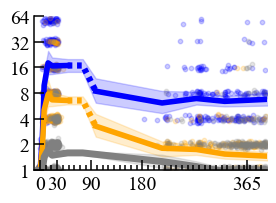

In [43]:

# Function for bootstrapped confidence intervals using log2 transformation
def bootstrap_confidence_interval_log2_shifted(data, shift_factor, num_bootstrap=1000, confidence=0.95):
    if len(data) == 0:
        return np.nan, np.nan  # Return NaN if there's no data
    log_data = np.log2(data * shift_factor)
    boot_means = [np.mean(np.random.choice(log_data, size=len(log_data), replace=True)) for _ in range(num_bootstrap)]
    lower_bound_log = np.percentile(boot_means, (1 - confidence) / 2 * 100)
    upper_bound_log = np.percentile(boot_means, (1 + confidence) / 2 * 100)
    return 2 ** lower_bound_log, 2 ** upper_bound_log

# Function to apply bins and calculate smoothed fold change (means and CIs)
def apply_bins_with_neighbors(days, fold_changes, bins, apply_smoothing=True, extend_to_day_75=True):
    weights = {'current': 1, 'one_bin_away': 0.25}
    precomputed_bin_means = [np.exp(np.mean(np.log(fold_changes[(days >= start) & (days <= end)])))
                             if len(fold_changes[(days >= start) & (days <= end)]) > 0 else np.nan for start, end in bins]
    precomputed_bin_cis = [bootstrap_confidence_interval_log2_shifted(
        fold_changes[(days >= start) & (days <= end)], 1)
        if len(fold_changes[(days >= start) & (days <= end)]) > 0 else (np.nan, np.nan) for start, end in bins]

    bin_means, bin_cis, bin_counts = [], [], []

    for bin_index, (start, end) in enumerate(bins):
        bin_fc_values = fold_changes[(days >= start) & (days <= end)]
        count = len(bin_fc_values)
        current_bin_mean = precomputed_bin_means[bin_index]
        current_ci_lower, current_ci_upper = precomputed_bin_cis[bin_index]

        # Apply smoothing only if requested and the bin has data
        # if apply_smoothing and not np.isnan(current_bin_mean):
        if apply_smoothing and not np.isnan(current_bin_mean) and (start, end) != (0,0):
            total_weight = weights['current']
            weighted_fc_sum = current_bin_mean * total_weight
            weighted_ci_lower_sum = current_ci_lower * total_weight
            weighted_ci_upper_sum = current_ci_upper * total_weight

            if bin_index - 1 >= 0 and not np.isnan(precomputed_bin_means[bin_index - 1]):
                prev_bin_mean = precomputed_bin_means[bin_index - 1]
                prev_ci_lower, prev_ci_upper = precomputed_bin_cis[bin_index - 1]

                weighted_fc_sum += prev_bin_mean * weights['one_bin_away']
                weighted_ci_lower_sum += prev_ci_lower * weights['one_bin_away']
                weighted_ci_upper_sum += prev_ci_upper * weights['one_bin_away']
                total_weight += weights['one_bin_away']

            if bin_index + 1 < len(bins) and not np.isnan(precomputed_bin_means[bin_index + 1]):
                next_bin_mean = precomputed_bin_means[bin_index + 1]
                next_ci_lower, next_ci_upper = precomputed_bin_cis[bin_index + 1]

                weighted_fc_sum += next_bin_mean * weights['one_bin_away']
                weighted_ci_lower_sum += next_ci_lower * weights['one_bin_away']
                weighted_ci_upper_sum += next_ci_upper * weights['one_bin_away']
                total_weight += weights['one_bin_away']

            # Calculate smoothed values
            bin_mean_fc = weighted_fc_sum / total_weight
            smoothed_ci_lower = weighted_ci_lower_sum / total_weight
            smoothed_ci_upper = weighted_ci_upper_sum / total_weight
        else:
            bin_mean_fc = current_bin_mean
            smoothed_ci_lower = current_ci_lower
            smoothed_ci_upper = current_ci_upper

        # Add midpoint and optionally extend to day 75 for (22, 75) bin
        if (start, end) == (22, 75):
            bin_means.append((48.5, bin_mean_fc))  # Midpoint for (22, 75)
            bin_cis.append((smoothed_ci_lower, smoothed_ci_upper))
            bin_counts.append(count)
            if extend_to_day_75:
                bin_means.append((75, bin_mean_fc))  # Extend to day 75 with the same value
                bin_cis.append((smoothed_ci_lower, smoothed_ci_upper))
                bin_counts.append(count)
        else:
            bin_means.append(((start + end) / 2, bin_mean_fc))
            bin_cis.append((smoothed_ci_lower, smoothed_ci_upper))
            bin_counts.append(count)

    return bin_means, bin_cis, bin_counts

# Function to get group data
def get_group_data(df, groups, group_names, fold_change = True):
    """Create a dictionary containing Days and Fold-Changes for each group."""
    group_dict = {name: {'Days': [], 'Fold-Changes': []} for name in group_names}
    for i, group in enumerate(groups):
        vac_data = df[df['Subject'].isin(group) & (df['Virus'] == df['Vaccine Strain'])]
        group_dict[group_names[i]]['Days'] = vac_data['Day'].values
        if fold_change == True :
            group_dict[group_names[i]]['Fold-Changes'] = vac_data['Fold-change'].values
        else :
            group_dict[group_names[i]]['Fold-Changes'] = vac_data['HAI'].values
    return group_dict

# Main plotting function
def plotFC_new(df, groups, group_names, bins, dash_start, dash_end, dashed_groups = None, replacement_groups=None, replacement_bin=(76, 109),
               colors=['blue', 'orange', 'gray'], linewidths=[6, 6, 6], figsize=(8, 6),
               xlimit=(0, 400), ylimit=(1, 64), spinewidth=1.1, showEveryDay=False, 
               major_tick_length=7, minor_tick_length=3.5, alpha = 0.8, major_x_ticks=None, tick_width=1.1, labelsize=14, 
               apply_smoothing=True, extend_to_day_75=True, jitter_days = 4, jitter_factor = 0.01, markersize = 10, show_individual_responses = False,clip_y = None, clip_x = None, start_x_minor_ticks = 0, empty = False, fold_change = True,  saveFigure = False, filename = None):

    # Generate group data
    group_dict = get_group_data(df, groups, group_names, fold_change = fold_change)
    replacement_dict = get_group_data(df, replacement_groups, group_names) if replacement_groups else None
    
    fig, ax = plt.subplots(figsize=figsize)

    for i, group_name in enumerate(group_names):
        days = group_dict[group_name]['Days']
        fold_changes = group_dict[group_name]['Fold-Changes']

        if show_individual_responses:
            serum_days = days
            serum_fc = fold_changes
            if clip_y :
                serum_fc = np.clip(fold_changes, 1, clip_y)
            if clip_x :
                serum_days = np.clip(days, None, clip_x)
            serum_fc_jittered = np.random.normal(serum_fc, jitter_factor * serum_fc)
            serum_days_jittered = serum_days + np.random.uniform(-jitter_days, jitter_days, size=len(serum_days))
            if empty == False:
                ax.scatter(serum_days_jittered, serum_fc_jittered, color=colors[i], alpha=alpha, s=markersize, zorder = 0)
            elif empty == False:
                ax.plot(serum_days_jittered, serum_fc_jittered, color=colors[i], alpha=alpha)

        # Apply smoothing and get bin means, CIs, and counts
        bin_means, bin_cis, bin_counts = apply_bins_with_neighbors(days, fold_changes, bins, apply_smoothing, extend_to_day_75)
        print(f"\n===== {group_name.upper()} =====")
        for j, ((midpoint, gm), (ci_low, ci_up), count) in enumerate(zip(bin_means, bin_cis, bin_counts)):
            bin_label = bins[j] if j < len(bins) else "(extended point)"
            print(f"Bin {bin_label} (mid={midpoint:.1f}): n={count:>3}, GM={gm:.2f}, CI=({ci_low:.2f}, {ci_up:.2f})")



        # Handle replacement bin only for durable and transient groups
        if group_name in ['durable', 'transient'] and replacement_bin:
            replacement_start, replacement_end = replacement_bin
            try:
                previous_bin_index = bins.index((22, 75))  # Get the index of the (22, 75) bin
                previous_bin_mean = bin_means[previous_bin_index][1] / 2 # Previous bin mean / 2
                replacement_days = np.array(replacement_dict[group_name]['Days'])
                replacement_fold_changes = np.array(replacement_dict[group_name]['Fold-Changes'])
                replacement_bin_values = replacement_fold_changes[(replacement_days >= replacement_start) & (replacement_days <= replacement_end)]

                replacement_mean = np.exp(np.mean(np.log(replacement_bin_values))) if len(replacement_bin_values) > 0 else np.nan
                ci_lower, ci_upper = bootstrap_confidence_interval_log2_shifted(replacement_bin_values, previous_bin_mean / replacement_mean)

                # Update the values for the replacement bin
                for j, (midpoint, y) in enumerate(bin_means):
                    if replacement_start <= midpoint <= replacement_end:
                        bin_means[j] = (midpoint, previous_bin_mean)
                        bin_cis[j] = (ci_lower, ci_upper)

            except (ValueError, IndexError):
                print(f"Skipping replacement for {group_name} due to missing bin data.")

        # Handle weak group to connect day 75 to (180, 250)
        if group_name == 'weak':
            found_76_109 = False
            for j, (start, end) in enumerate(bins):
                if (start, end) == (76, 120):
                    found_76_109 = True  # Skip this bin for weak
                elif found_76_109 and (start, end) == (180, 250):
                    # Connect from day 75 to (180, 250)
                    # bin_means[j - 1, 1] = bin_means[bins.index((22, 75)), 1]
                    bin_means[j - 1] = (bin_means[j - 1][0], bin_means[bins.index((22, 75))][1])


        # Extract values for plotting
        bin_means = np.array(bin_means)
        bin_cis = np.array(bin_cis)
        bin_counts = np.array(bin_counts)

        x_vals = bin_means[:, 0]  # Bin midpoints
        y_vals = bin_means[:, 1]  # Geometric mean fold changes
        ci_lower = bin_cis[:, 0]  # Lower bound of CI
        ci_upper = bin_cis[:, 1]  # Upper bound of CI

        # Remove NaNs for plotting
        valid = ~np.isnan(y_vals)
        x_vals, y_vals, ci_lower, ci_upper = x_vals[valid], y_vals[valid], ci_lower[valid], ci_upper[valid]

        # Plot line
        if dash_start is not None and dash_end is not None and empty == False and group_name in dashed_groups:
            ax.plot(x_vals[:dash_start], y_vals[:dash_start], color=colors[i], linewidth=linewidths[i], zorder = 2)
            ax.plot(x_vals[dash_end:], y_vals[dash_end:], color=colors[i], linewidth=linewidths[i], zorder = 2)
            
            # Plot dashed line for the specified range
            ax.plot(x_vals[dash_start-1:dash_end+1], y_vals[dash_start-1:dash_end+1], linestyle=(0, (0.75,0.75)), color=colors[i], linewidth=linewidths[i]+0.5, zorder = 10)
        elif empty == False:    
            ax.plot(x_vals, y_vals, label=group_name.capitalize(), color=colors[i], linewidth=linewidths[i])

        # Plot shaded confidence intervals
        if empty == False:
            ax.fill_between(x_vals, ci_lower, ci_upper, color=colors[i], alpha=0.2)

    #Axis settings
    ax.set_xscale('linear')
    ax.set_yscale('log', base=2)
    
    ax.set_ylim(ylimit)
    ax.set_xticks(major_x_ticks)
    if fold_change == True :
        ax.set_yticks([1, 2, 4, 8, 16, 32, 64])
        ax.set_yticklabels([str(ytick) for ytick in [1, 2, 4, 8, 16, 32, 64]])
    else :
        ax.set_yticks([10, 40, 160, 640, 2560])
        ax.set_yticklabels([str(ytick) for ytick in [10, 40, 160, 640, 2560]])
        minor_ticks = [5, 20, 80, 320, 1280]
        ax.set_yticks(minor_ticks, minor = True)
        ax.yaxis.set_minor_formatter(NullFormatter())
        # ax.set_yticklabels([str(ytick) for ytick in [5, 20, 80, 320, 1280]], minor = True)
    ax.set_xlim(xlimit)

    # if showEveryDay:
    #     ax.xaxis.set_minor_locator(ticker.MultipleLocator(showEveryDay))
    if showEveryDay:
        minor_ticks = np.arange(start_x_minor_ticks, xlimit[1], showEveryDay)  # Only generate minor ticks from 0 onwards
        ax.set_xticks(minor_ticks, minor=True)

  

    ax.tick_params(axis='both', which='major', length=major_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 10)
    ax.tick_params(axis='both', which='minor', length=minor_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 10)
    ax.tick_params(axis='x', which='minor', length=minor_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 10)

    # Customize spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_linewidth(spinewidth)
    ax.spines['left'].set_linewidth(spinewidth)
    ax.set_axisbelow(False)
    ax.autoscale(enable=False, axis='x')  # Force-disable autoscaling
    
    # plt.tight_layout()
    if saveFigure == True :
        plt.savefig(filename, transparent = True, dpi = 300)
    ax.set_xlim(xlimit)        
    fig.canvas.draw()
    plt.show()



bins = [(0, 0), (4, 4), (7, 7), (14, 14), (21, 21), (22, 75), (76, 120), (180, 250), (251, 300), (301, 350), (351, 500)] 
major_x_ticks = [0, 30, 90, 180, 365]
ylimit = (4, 64)
xlimit = (-10, 400)

try:
    _=durable_uga2022
    replacement_groups = [durable_uga2022, transient_uga2022]
    replacement_bin = (76,120)
    dash_start=6
    dash_end=7
    df = pd.concat([master, master_uga2022], ignore_index=True)
    
except:
    replacement_groups = None
    replacement_bin = None
    dash_start=6
    dash_end=6
    df=master




fold_change = True


plotFC_new(df, groups=[durable, transient, weak], empty = False, group_names=['durable', 'transient', 'weak'],
           bins=bins, replacement_groups=replacement_groups, replacement_bin=replacement_bin, apply_smoothing=True, 
           extend_to_day_75=True, dash_start = dash_start, showEveryDay = 10, clip_y=57,clip_x=395, linewidths=[4, 4, 5], alpha = 0.2, jitter_factor = 0.045, labelsize = 14, show_individual_responses = True, fold_change = fold_change, xlimit = xlimit,colors = ['blue', 'orange', 'gray'], ylimit = ylimit, dash_end = dash_end,  major_x_ticks = major_x_ticks, saveFigure = False,  dashed_groups = ['durable', 'transient'], figsize=(3, 2))

## 1C: Fraction of Phenotypes across Studies

2014 Hin_V
  Durable:   4 (9.8%)
  Transient: 1 (2.4%)
  Weak:      36 (87.8%)

2016 Fox_Nam
  Durable:   51 (52.6%)
  Transient: 21 (21.6%)
  Weak:      25 (25.8%)

2016 Fox_HCW
  Durable:   8 (16.3%)
  Transient: 10 (20.4%)
  Weak:      31 (63.3%)

2016 UGA
  Durable:   35 (34.3%)
  Transient: 20 (19.6%)
  Weak:      47 (46.1%)

2017 UGA
  Durable:   12 (8.0%)
  Transient: 20 (13.3%)
  Weak:      118 (78.7%)

2018 UGA
  Durable:   11 (6.8%)
  Transient: 20 (12.3%)
  Weak:      131 (80.9%)

2019 UGA
  Durable:   58 (18.1%)
  Transient: 85 (26.6%)
  Weak:      177 (55.3%)

2020 UGA
  Durable:   16 (6.4%)
  Transient: 39 (15.6%)
  Weak:      195 (78.0%)

2021 UGA
  Durable:   15 (9.7%)
  Transient: 22 (14.2%)
  Weak:      118 (76.1%)



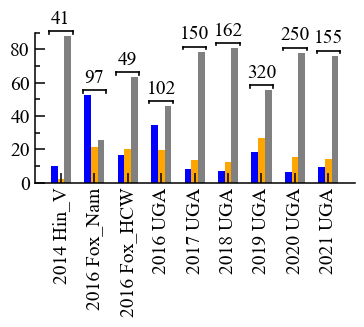

In [27]:
def percentGroupPerDataset(df, dataset_list, saveFigure=False, filename=None, labelsize=10, groups=[durable, transient, weak]):
    group_labels = ['Durable', 'Transient', 'Weak']
    dic = {'Durable': [], 'Transient': [], 'Weak': []}
    plt.rcParams['font.family'] = 'Times New Roman'

    # Calculate the percent of each group in each dataset
    N_values = []  # To store the count for each dataset
    for dataset in dataset_list:
        dataset_sera = set(df[df['Dataset'] == dataset]['Subject'].unique())
        
        durable_dataset = set(durable).intersection(dataset_sera)
        transient_dataset = set(transient).intersection(dataset_sera)
        weak_dataset = set(weak).intersection(dataset_sera)

        qualifiable = durable_dataset.union(transient_dataset).union(weak_dataset)

        if len(qualifiable) > 0:
            percent_durable = len(durable_dataset) / len(qualifiable) * 100
            percent_transient = len(transient_dataset) / len(qualifiable) * 100
            percent_weak = len(weak_dataset) / len(qualifiable) * 100
        else:
            percent_durable = percent_transient = percent_weak = 0  # Handle case with no sera

        print(f"{dataset}")
        print(f"  Durable:   {len(durable_dataset)} ({percent_durable:.1f}%)")
        print(f"  Transient: {len(transient_dataset)} ({percent_transient:.1f}%)")
        print(f"  Weak:      {len(weak_dataset)} ({percent_weak:.1f}%)\n")

        dic['Durable'].append(percent_durable)
        dic['Transient'].append(percent_transient)
        dic['Weak'].append(percent_weak)
        N_values.append(len(qualifiable))  # Store the N value for each dataset

    # Plotting the results
    x = np.arange(len(dataset_list))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(4, 2))
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)

    # Create bars for each group
    rects1 = ax.bar(x - width, dic['Durable'], width, label='Durable', color='blue')
    rects2 = ax.bar(x, dic['Transient'], width, label='Transient', color='orange')
    rects3 = ax.bar(x + width, dic['Weak'], width, label='Weak', color='gray')
    
    # Plot appearance
    ax.spines['bottom'].set_linewidth(1.1)
    ax.spines['left'].set_linewidth(1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_list, rotation=90, ha='center')
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(axis='y', which='minor', direction='in', length=3.5, width=1.1,  pad = 10)
    ax.tick_params( direction='in', length=7, width=1.1, labelsize=labelsize)
    ax.set_ylim(0, 90)
    # ax.legend()

    # Add N labels centered over the middle bar (Transient) and slightly above the highest bar for each dataset
    for idx, (d, t, w) in enumerate(zip(dic['Durable'], dic['Transient'], dic['Weak'])):
        max_height = max(d, t, w)  # Determine the highest bar for each dataset
        N_text = f'{N_values[idx]}'
        
        # Position the N label above the highest bar
        ax.text(x[idx], max_height + 5, N_text, ha='center', va='bottom', fontsize=labelsize, color='black')

        # Draw a horizontal bracket under the N label
        bracket_y = max_height + 3  # Set y-position for the bracket line
        ax.plot([x[idx] - width - 0.15, x[idx] + width + 0.15], [bracket_y, bracket_y], color='black', lw=1.2, clip_on=False)  # Horizontal line
        ax.plot([x[idx] - width - 0.15, x[idx] - width-0.15], [bracket_y, bracket_y - 1.5], color='black', lw=1.2, clip_on=False)  # Left vertical
        ax.plot([x[idx] + width + 0.15, x[idx] + width+0.15], [bracket_y, bracket_y - 1.5], color='black', lw=1.2, clip_on=False)  # Right vertical

    # plt.tight_layout()
    if saveFigure:
        plt.savefig(filename, dpi = 300, transparent=True)
    return dic
    plt.show()
    print(dic)


# dataset_list = ['2014 Hin_V', '2016 UGA', '2017 UGA', '2018 UGA', '2019 UGA',
#        '2020 UGA', '2021 UGA', '2022 UGA']
dataset_list = ['2014 Hin_V', '2016 Fox_Nam',
       '2016 Fox_HCW', '2016 UGA', '2017 UGA', '2018 UGA', '2019 UGA',
       '2020 UGA', '2021 UGA']


dataset_dic = percentGroupPerDataset(master, dataset_list, labelsize = labelsize)

# Figure 2

## 2A: Male vs Female

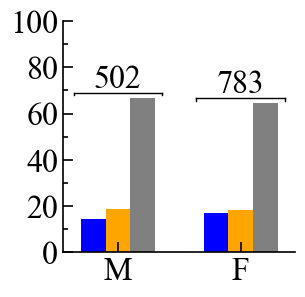

In [197]:


datasets = ['2014 Hin_V','2016 Fox_Nam',
       '2016 Fox_HCW', '2016 UGA', '2017 UGA', '2018 UGA', '2019 UGA',
       '2020 UGA', '2021 UGA']


has_phenotype = set(weak).union(set(transient))
has_phenotype = list(has_phenotype.union(set(durable)))

def plot_distribution_across_factors(df, datasets, groups, group_names, group_colors, 
                                      category_col, categories, figsize, labelsize=23, 
                                      saveFigure=False, filename=None):
 

    fig, ax = plt.subplots(figsize=figsize)
    x_positions = np.arange(len(categories))
    bar_width = 0.2

    # Filter to relevant subjects
    df_filtered = df[df['Dataset'].isin(datasets) & df['Subject'].isin(has_phenotype)&(df['Virus']==df['Vaccine Strain'])]

    # Count total sera per category
    total_per_cat = np.array([df_filtered[df_filtered[category_col] == cat]['Subject'].nunique() for cat in categories])

    # Count sera per group within each category
    group_counts_per_cat = np.zeros((len(groups), len(categories)))
    for i, group_sera in enumerate(groups):
        for j, cat in enumerate(categories):
            sub_df = df_filtered[(df_filtered[category_col] == cat) & df_filtered['Subject'].isin(group_sera)]
            group_counts_per_cat[i, j] = sub_df['Subject'].nunique()

    # Convert to percentages
    group_percentages = (group_counts_per_cat / total_per_cat) * 100
    group_percentages = np.nan_to_num(group_percentages)

    for i, group_name in enumerate(group_names):
        ax.bar(x_positions + i * bar_width, group_percentages[i], width=bar_width, 
               color=group_colors[i], label=group_name, alpha=1, edgecolor=None)

    # Brackets and counts above bars
    max_heights = np.max(group_percentages, axis=0)
    bracket_offset = 2
    for i, (x_pos, total) in enumerate(zip(x_positions, total_per_cat)):
        y_pos = max_heights[i] + bracket_offset
        left_x = x_pos - (bar_width * 0.8)
        right_x = x_pos + (bar_width * 0.8) + (bar_width * (len(groups) - 1))
        ax.plot([left_x, right_x], [y_pos, y_pos], color='black', lw=1, clip_on=False)
        ax.plot([left_x, left_x], [y_pos, y_pos - 1.1], color='black', lw=1, clip_on=False)
        ax.plot([right_x, right_x], [y_pos, y_pos - 1.1], color='black', lw=1, clip_on=False)
        ax.text(x_pos + (bar_width * (len(groups) - 1) / 2), y_pos + 2.4, f"{int(total)}",
                ha='center', fontsize=labelsize)

    # X-axis ticks and labels
    ax.set_xticks(x_positions + (bar_width * (len(groups) - 1) / 2))
    ax.set_xticklabels(categories, fontsize=labelsize)
    ax.tick_params(axis='x', length=7, width=1.2, direction='in')

    # Y-axis formatting
    y_major_ticks = [0, 20, 40, 60, 80, 100]
    y_minor_ticks = [10, 30, 50, 70, 90]
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='y', which='major', length=7, labelsize=labelsize, 
                   direction='in', width=1.2, zorder=10)
    ax.tick_params(axis='y', which='minor', length=3.5, labelsize=0, 
                   direction='in', width=1.2, zorder=10)
    ax.set_ylim(0, 100)

    # Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    if saveFigure and filename:
        plt.savefig(filename, transparent=True)
    plt.show()

plot_distribution_across_factors(master, datasets, [durable,transient,weak], ['durable', 'transient', 'weak'], ['blue', 'orange', 'gray'],
                                                category_col = 'Sex', categories = ['M', 'F'], figsize = (3,3))

## 2B: Fluzone Vaccine Dose

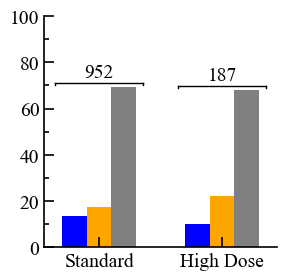

In [198]:
plot_distribution_across_factors(master, datasets, [durable,transient,weak], ['durable', 'transient', 'weak'], ['blue', 'orange', 'gray'],
                                                category_col = 'Vaccine Dose', categories = ['Standard', 'High Dose'], figsize = (3,3), labelsize = 14)

## 2C: Age

In [171]:
master[(master['Age']<=19) & (master['Subject'].isin(has_phenotype))&(master['Dataset'].isin(datasets))].drop_duplicates().Subject.nunique()

303

In [192]:
master[(master['Age Bin'] == '5-19') & (master['Subject'].isin(has_phenotype))].Subject.nunique()


344

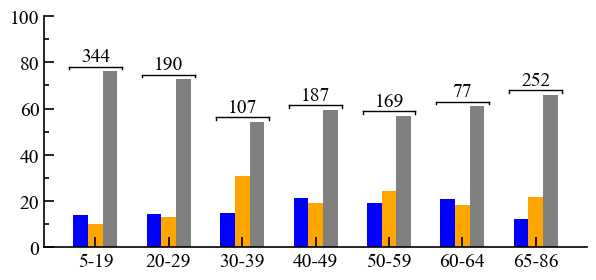

In [199]:
age_bins = [5, 20, 30, 40, 50, 60, 65, 87]  # 87 is upper bound (non-inclusive)
age_labels = ['5-19', '20-29', '30-39', '40-49', '50-59', '60-64', '65-86']

master['Age Bin'] = pd.cut(master['Age'], bins=age_bins, labels=age_labels, right=False)

plot_distribution_across_factors(master, datasets, [durable,transient,weak], ['durable', 'transient', 'weak'], ['blue', 'orange', 'gray'],
                                                category_col = 'Age Bin', categories = age_labels, figsize = (7,3), labelsize = 14)


## 2D: Pre-vac HAI

In [ ]:
# master.drop(columns=['Pre-vac_x', 'Pre-vac_y'], inplace =)

In [223]:
# Step 1: Extract Day 0 rows
day0_vaccine = master[(master['Day'] == 0)&(master['Virus']==master['Vaccine Strain'])][['Subject', 'Virus', 'HAI']]
day0_vaccine = day0.rename(columns={'HAI': 'Pre-vac'})

# Step 2: Merge Day 0 HAI into the full dataframe based on Subject and Virus
master = master.merge(day0, on=['Subject', 'Virus'], how='left')

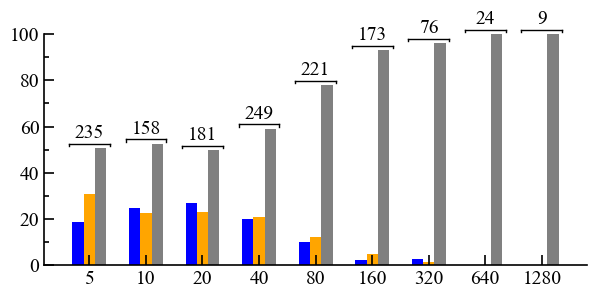

In [200]:


prevac_titers = [5,10,20,40,80,160,320,640,1280]

plot_distribution_across_factors(master, datasets, [durable,transient,weak], ['durable', 'transient', 'weak'], ['blue', 'orange', 'gray'],
                                                category_col = 'Pre-vac', categories = prevac_titers, figsize = (7,3), labelsize = 14)



## 2E: Vaccinations in Last 5 Years

In [212]:
master = master.merge(vac_hist[['Subject', 'Vacs Last 5 Years']], on = 'Subject', how = 'left')

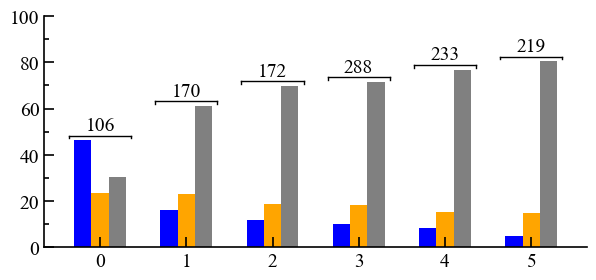

In [215]:
prior_vacs = [0,1,2,3,4,5]

plot_distribution_across_factors(master, datasets, [durable,transient,weak], ['durable', 'transient', 'weak'], ['blue', 'orange', 'gray'],
                                                category_col = 'Vacs Last 5 Years', categories = prior_vacs, figsize = (7,3), labelsize = 14)


## 2F: Random Forest

              precision    recall  f1-score   support

     Durable       0.64      0.45      0.53        31
   Transient       0.51      0.79      0.62        61
        Weak       0.97      0.89      0.93       313

    accuracy                           0.84       405
   macro avg       0.71      0.71      0.69       405
weighted avg       0.87      0.84      0.85       405

Feature importances:
 Month FC             0.529071
Age                  0.214274
Vacs Last 5 Years    0.113653
Pre-vac              0.105586
Sex                  0.027745
Vaccine Dose         0.009671
dtype: float64
Overall Accuracy: 0.844
[[ 14  15   2]
 [  6  48   7]
 [  2  31 280]]


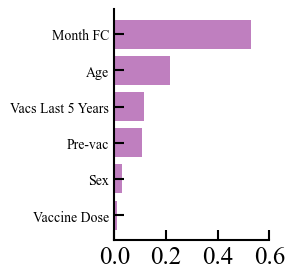

In [ ]:


# filter to include values for all variables
master_valid = (
    master[(master['Vaccine Brand'] == 'Fluzone')&
    (master['Virus']==master['Vaccine Strain'])]
    .dropna()
    .drop_duplicates(subset='Subject')
    .reset_index(drop=True)
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode categorical variables
master_valid['Sex'] = LabelEncoder().fit_transform(master_valid['Sex'])  # F=0, M=1
master_valid['Vaccine Dose'] = LabelEncoder().fit_transform(master_valid['Vaccine Dose'])  # Standard=0, High=1 or whatever present

master_valid['Pre Vac HAI Log'] = np.log2(master_valid['Pre-vac']/5)
# Filter only rows that are the Day28p vaccine strain rows
month_fc_df = master[(master['Proxy Day'] == 'Day28p') &
                     (master['Virus'] == master['Vaccine Strain'])][['Subject', 'Fold-change']].copy()
month_fc_df = month_fc_df.rename(columns={'Fold-change': 'Month FC'})

# Merge into master_valid
master_valid = master_valid.merge(month_fc_df, on='Subject', how='left')
# add phenotype
def add_phenotype(subject):
    if subject in weak:
        return 'Weak'
    elif subject in transient:
        return 'Transient'
    elif subject in durable:
        return 'Durable'
master_valid['Phenotype'] = master_valid['Subject'].apply(add_phenotype)


# Train-test split
training_datasets = ['2016 UGA',
                     '2017 UGA',
                     '2018 UGA',
                     '2019 UGA']
testing_datasets = ['2020 UGA', '2021 UGA']
training_data = master_valid[master_valid['Dataset'].isin(training_datasets)].copy()
testing_data = master_valid[master_valid['Dataset'].isin(testing_datasets)].copy()

# Define features and target
features = ['Age', 'Sex', 'Vaccine Dose', 'Month FC', 'Vacs Last 5 Years', 'Pre-vac']
# features = ['Pre Vac HAI']
X_train = training_data[features]
y_train = training_data['Phenotype']
X_test = testing_data[features]
y_test = testing_data['Phenotype']


# Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importances
importances = pd.Series(clf.feature_importances_, index=features)
print("Feature importances:\n", importances.sort_values(ascending=False))

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {acc:.3f}")

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred, labels=clf.classes_))

import matplotlib.pyplot as plt

# Sort importances for plotting
sorted_importances = importances.sort_values(ascending=True)  # ascending=True for horizontal plot

fig, ax = plt.subplots(figsize=(2, 3))
ax.barh(sorted_importances.index, sorted_importances.values, color='purple',alpha = 0.5)

tick_width = 1.5
ax.set_xticks([0, 0.2, 0.4, 0.6])
ax.tick_params(which='major', direction='in', length=7,
                width=tick_width, zorder=4)
ax.tick_params(axis='x', labelsize = 18)
ax.yaxis.set_tick_params(pad=4)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(tick_width)
ax.spines['left'].set_linewidth(tick_width)

plt.show()




# Figure 3

## 2016 Fox Nam - Early Response


===== DURABLE =====
Bin (0, 0) (mid=0.0): n= 51, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 51, GM=1.29, CI=(1.15, 1.46)
Bin (7, 7) (mid=7.0): n= 51, GM=9.16, CI=(6.35, 13.78)
Skipping replacement for durable due to missing bin data.

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n= 21, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 21, GM=1.30, CI=(1.07, 1.59)
Bin (7, 7) (mid=7.0): n= 21, GM=5.04, CI=(3.62, 7.25)
Skipping replacement for transient due to missing bin data.

===== WEAK =====
Bin (0, 0) (mid=0.0): n= 25, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 25, GM=0.92, CI=(0.76, 1.09)
Bin (7, 7) (mid=7.0): n= 25, GM=1.43, CI=(1.18, 1.74)


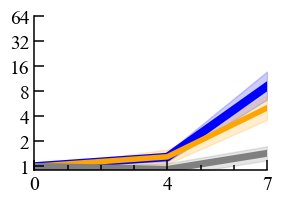

In [28]:
#
##
# Plotting the early response from the 2016 Fox_Nam study
#
fox_nam = master[master['Dataset'] == '2016 Fox_Nam'].copy()
fox_nam_durable = list(set(fox_nam[fox_nam['Subject'].isin(durable)]['Subject'].unique()))
fox_nam_transient = list(set(fox_nam[fox_nam['Subject'].isin(transient)]['Subject'].unique()))
fox_nam_weak = list(set(fox_nam[fox_nam['Subject'].isin(weak)]['Subject'].unique()))

fox_nam_bins = ([(0,0), (4,4), (7,7)])
plotFC_new(groups=[fox_nam_durable, fox_nam_transient, fox_nam_weak], group_names=['durable', 'transient', 'weak'], apply_smoothing=False,linewidths =[6,4,5],major_x_ticks = [0,4,7], showEveryDay=True, xlimit=(0,7),ylimit=(0.9,64), figsize=(3, 2), bins = fox_nam_bins, dash_start=None, dash_end=None,)


Weak Response [0, 4, 7] [0, 0.0, 4.0]
Transient Response [0, 4, 7] [0, 4.761904761904762, 80.95238095238095]
Durable Response [0, 4, 7] [0, 5.88235294117647, 82.35294117647058]


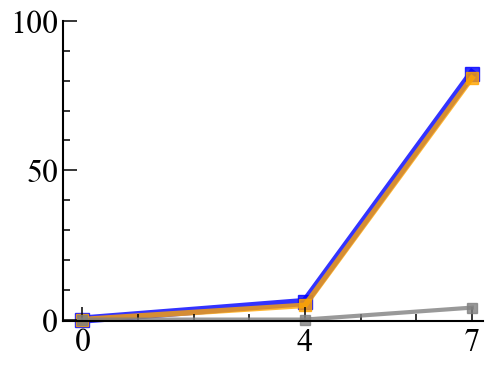

In [29]:

markersizes=[10, 9, 7]
linewidths = [6,4,3]
color_dic = {
    'Durable Response': 'blue',
    'Transient Response': 'orange',
    'Weak Response': 'gray'
}

linewidth_dic = {
'Durable Response' : linewidths[0],
'Transient Response' : linewidths[1],
'Weak Response' : linewidths[2]}

markersize_dic = {
    'Durable Response' : markersizes[0],
    'Transient Response' : markersizes[1],
    'Weak Response' : markersizes[2]}

# markersizes = [45, 45, 45]

def plotGroupFoldChangePercentage(df, days, groups, colors=color_dic, dayToHighlight='Day7', spinewidth=1.5, linewidths=[3, 3, 5], markersizes=[1,1,1], threshold=4, figsize=(6, 4), major_tick_length=7, minor_tick_length=3.5, tick_width=1, saveFigure=False, filename=False):
    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)
    plt.rcParams['font.family'] = 'Times New Roman'

    # linewidth_dic = {
    # 'Durable Response' : linewidths[0],
    # 'Transient Response' : linewidths[1],
    # 'Weak Response' : linewidths[2]}

    # markersize_dic = {
    #     'Durable Response' : markersizes[0],
    #     'Transient Response' : markersizes[1],
    #     'Weak Response' : markersizes[2]}


    for group_name, sera in groups.items():
        # Pre-calculate the day each serum reaches its max fold-change if threshold is 'max_cum'
        serum_max_day = {}
        serum_max_value = {}
        
        if threshold == 'max_cum':
            for serum in sera:
                day0Data = df[(df['Subject'] == serum) & (df['Day'] == 0) & (df['Virus']==df['Vaccine Strain'])]['HAI'].values
                if len(day0Data) > 0:
                    day0Value = day0Data[0]
                    serum_data = df[(df['Subject'] == serum) & (df['Virus'] == df['Vaccine Strain'])].copy()
                    serum_max_value[serum] = serum_data['Fold-Change'].max()
                    
                    # Get the first day where the serum reaches its maximum fold-change
                    max_day = serum_data.loc[serum_data['FoldChange'] == serum_max_value[serum], 'Day'].min()
                    serum_max_day[serum] = max_day
    
        percentages = [0]
        
        for i in range(1, len(days)):
            count_with_threshold = 0
            total_count = 0
            
            for serum in sera:
                day0Data = df[(df['Subject'] == serum) & (df['Day'] == 0) & (df['Virus'] == df['Vaccine Strain'])]['HAI'].values
                dayXData = df[(df['Subject'] == serum) & (df['Day'] == days[i]) & (df['Virus'] == df['Vaccine Strain'])]['HAI'].values

                if threshold == 'max':
                    # Calculate max fold change on each day independently
                    serum_max = df[(df['Subject'] == serum) & (df['Virus'] == df['Vaccine Strain'])]['HAI'].max()
                    serum_max_fold_change = serum_max / day0Data
                    if len(day0Data) > 0 and len(dayXData) > 0:
                        foldChange = dayXData[0] / day0Data[0]
                        if foldChange >= serum_max_fold_change:
                            count_with_threshold += 1
                        total_count += 1

                if threshold == 'max_cum':
                    # Ensure max day was reached by or on the current day
                    if serum in serum_max_day:
                        total_count += 1
                        max_value = serum_max_value[serum]
                        current_day_data = df[(df['Serum'] == serum) & 
                                            (df['Day'] == days[i]) & 
                                            (df['Virus'] == df['Vaccine Strain'])]['HAI'].values[0]
                        current_fold_change = current_day_data / day0Data[0]
        
                        # Check if they've reached their max by this day
                        if current_fold_change >= max_value or days[i] >= serum_max_day[serum]:
                            count_with_threshold += 1
                
                else:
                    # Standard threshold comparison
                    if len(day0Data) > 0 and len(dayXData) > 0:
                        foldChange = dayXData[0] / day0Data[0]
                        if foldChange >= threshold:
                            count_with_threshold += 1
                        total_count += 1
            
            # Calculate the percentage of sera with fold change ≥ threshold
            percentage = (count_with_threshold / total_count) * 100 if total_count > 0 else 0
            percentage = min(percentage, 100)  # Clip at 95%
            percentages.append(percentage)
        
        # Plotting the percentage line for the group
        zorder = 3
        linewidth = linewidths[2]
        if group_name == 'Durable Response':
            zorder = 1
            linewidth = linewidths[0]
        if group_name == 'Transient Response':
            linewidth = linewidths[1]
            zorder = 2
        
        ax.plot(days, percentages, marker='s', zorder=zorder, alpha=0.8, linestyle='-', markersize=markersize_dic[group_name], color=colors[group_name], clip_on = False, linewidth=linewidth_dic[group_name], label=f"{group_name}\n(N = {len(sera)})")

        print(group_name, days, percentages)
    # # Set the x-ticks to include all days from 0 to 14
    # all_days = np.arange(0, 15)
    # ax.set_xticks(all_days)
    
    # # Set the x-tick labels, only labeling days 0, 4, 7, and 14
    # labels = [''] * 15
    # for day in days:
    #     labels[day] = str(day)
    # ax.set_xticklabels(labels)

    # Add a cute vertical dashed line on day 7
    if dayToHighlight == 'Day7':
        begin = 6.5; end = 7.5
        color = 'pink'
    elif dayToHighlight == 'Day4':
        begin = 3.5; end = 4.5
        color = 'lavender'
    if dayToHighlight :
        ax.axvspan(begin, end, color=color, alpha=0.7, zorder=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='both', direction='in', which='both', width=4, length=10, zorder = 10)
    # ax.tick_params(axis='both', labelsize=labelsize, zorder = 10)

    # Major ticks and labels for x-axis
    x_ticks_major = days
    ax.set_xticks(x_ticks_major)
    ax.set_xticklabels(x_ticks_major)
    ax.set_xlim(days[0]-0.35, days[-1] + 0.2)  # Change this to exactly 14

    ax.set_ylim(-0.5, 100)
    
    # Minor ticks every day on the x-axis
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_tick_params(pad=5)
    
    # Ensure no minor ticks appear after 14
    # ax.set_xticks([tick for tick in ax.get_xticks(minor=True) if tick <= 7], minor=True)
    ax.set_xticks([tick for tick in ax.get_xticks(minor=True) if tick <= days[-1] and tick >= days[0]], minor=True)

    
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(50))
    ax.tick_params(axis='both', direction='in', which='both', width=4, length=10, zorder = 10)
    ax.tick_params(axis='both', labelsize=labelsize, zorder = 10)
    
    # Customize appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(spinewidth)
    ax.spines['left'].set_linewidth(spinewidth)
    ax.tick_params(axis='y', which='major', length=major_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 4)
    ax.tick_params(axis='y', which='minor', length=minor_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 4)
    ax.tick_params(axis='x', which='major', length=major_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 4)
    ax.tick_params(axis='x', which='minor', length=minor_tick_length, width=tick_width, direction='in', labelsize=labelsize, zorder = 4)
    ax.grid(False)

    # Ensure that ticks and gridlines are drawn above plot elements
    ax.set_axisbelow(False)
    
    # Set tick parameters
    ax.tick_params(axis='both', which='both', zorder=10)
    for spine in ax.spines.values():
        spine.set_zorder(10)



    # plt.tight_layout()
    
    if saveFigure:
        fig.savefig(filename, dpi = 300, transparent=True)
    
    plt.show()

groups = {
'Weak Response': fox_nam_weak,  
'Transient Response': fox_nam_transient,
'Durable Response' : fox_nam_durable
}

labelsize = 23
markersizes=[8, 11, 12]

plotGroupFoldChangePercentage(master, days=[0, 4, 7], markersizes=[8, 10, 100], dayToHighlight = False, major_tick_length = 10, minor_tick_length = 5, tick_width = 1.1, threshold = 4, groups=groups, saveFigure = False)


## 2010 Henn - Early Response


===== STRONG =====
Bin (0, 0) (mid=0.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (1, 1) (mid=1.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (2, 2) (mid=2.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (3, 3) (mid=3.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (5, 5) (mid=5.0): n=  7, GM=1.81, CI=(1.00, 4.00)
Bin (6, 6) (mid=6.0): n=  7, GM=3.62, CI=(1.22, 14.49)
Bin (7, 7) (mid=7.0): n=  7, GM=5.38, CI=(1.81, 19.50)
Bin (8, 8) (mid=8.0): n=  7, GM=10.77, CI=(4.88, 28.98)
Bin (9, 9) (mid=9.0): n=  7, GM=8.00, CI=(2.97, 21.59)
Bin (10, 10) (mid=10.0): n=  7, GM=17.67, CI=(8.83, 43.07)

===== WEAK =====
Bin (0, 0) (mid=0.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (1, 1) (mid=1.0): n=  7, GM=0.91, CI=(0.74, 1.00)
Bin (2, 2) (mid=2.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (3, 3) (mid=3.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (5, 5) (mid=5.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (6, 6) (mid=6.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (7, 7) (mid=7.0): n=  7, GM=0.74, CI=(0.41, 1.00)
Bin (8, 8) (mid=8.0): n=  7, GM=1.

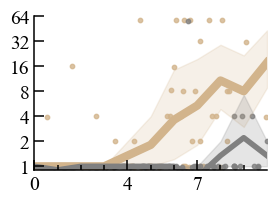

In [30]:
#
##
# Plotting the early response from the 2010 Henn study
#

henn = master[master['Dataset'] == '2010 Henn'].copy()
# split into weak and strong based solely on vaccine strain at day 21
henn_strong = henn[(henn['Day']==21)&
                   (henn['Fold-change']>=4)].Subject.unique().tolist()
henn_weak = henn[(henn['Day']==21)& 
                     (henn['Fold-change']<4)].Subject.unique().tolist()
henn_bins = ([(0,0), (1,1), (2,2), (3,3), (5,5),(6,6), (7,7), (8,8), (9,9), (10,10)])
plotFC_new(groups=[henn_strong, henn_weak], 
           group_names=['strong', 'weak'],
           colors = ['tan', 'gray'], 
           apply_smoothing=False,
           linewidths =[6,4,5],
           major_x_ticks = [0,4,7], 
           showEveryDay=True, 
           xlimit=(0,10),
           ylimit=(0.9,64), 
           figsize=(3, 2), 
           bins = henn_bins,
           show_individual_responses=True,
           jitter_factor=0.009, 
           dash_start=None, dash_end=None,
           clip_y=57)

 

Weak Response [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.285714285714285, 28.57142857142857, 14.285714285714285]
Strong Response [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0, 0.0, 0.0, 14.285714285714285, 28.57142857142857, 42.857142857142854, 42.857142857142854, 100.0, 85.71428571428571, 100.0]


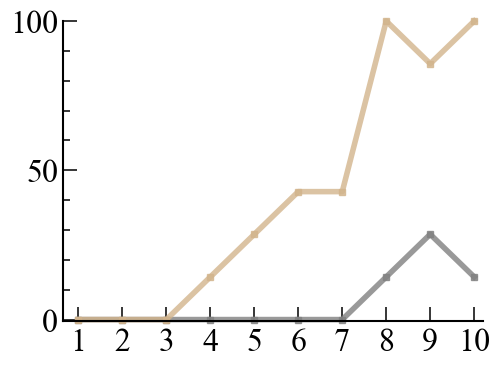

In [31]:
groups = {
    'Weak Response': henn_weak,  
    'Strong Response': henn_strong
}

colors = {
    'Weak Response': 'gray',
    'Strong Response': 'tan'
}

linewidth_dic = {
    'Weak Response': 4,
    'Strong Response': 4
}

markersize_dic = {
    'Weak Response': 4,
    'Strong Response': 4
}

# Pass the dictionaries to the function
plotGroupFoldChangePercentage(
    master, 
    days=[1,2,3,4,5,6,7,8,9,10], 
    groups=groups,
    colors=colors,  # Pass colors explicitly 
    dayToHighlight=False, 
    major_tick_length=10, 
    minor_tick_length=5, 
    tick_width=1.1, 
    threshold=4, 
    saveFigure=False
)

# Figure 4

## 4A: Geomean Dyanmics at Peak


===== DURABLE =====
Bin (0, 0) (mid=0.0): n=210, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 51, GM=2.56, CI=(1.99, 3.44)
Bin (7, 7) (mid=7.0): n= 51, GM=9.83, CI=(6.98, 14.28)
Bin (14, 14) (mid=14.0): n= 51, GM=18.11, CI=(13.43, 24.86)
Bin (21, 21) (mid=21.0): n=106, GM=16.69, CI=(13.53, 20.86)
Bin (22, 75) (mid=48.5): n=104, GM=16.87, CI=(14.22, 19.96)
Bin (76, 120) (mid=75.0): n=104, GM=16.87, CI=(14.22, 19.96)
Bin (extended point) (mid=98.0): n=  0, GM=nan, CI=(nan, nan)

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n=238, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 21, GM=1.87, CI=(1.48, 2.43)
Bin (7, 7) (mid=7.0): n= 21, GM=5.05, CI=(3.65, 7.21)
Bin (14, 14) (mid=14.0): n= 21, GM=7.75, CI=(5.73, 10.85)
Bin (21, 21) (mid=21.0): n= 71, GM=6.68, CI=(5.64, 8.07)
Bin (22, 75) (mid=48.5): n=167, GM=6.56, CI=(5.90, 7.42)
Bin (76, 120) (mid=75.0): n=167, GM=6.56, CI=(5.90, 7.42)
Bin (extended point) (mid=98.0): n=  0, GM=nan, CI=(nan, nan)

===== WEAK =====
Bin (0, 0) (mid=0.

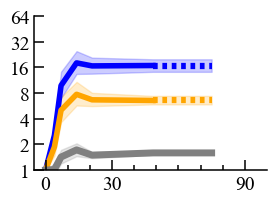

In [42]:
bins = [(0, 0), (4, 4), (7, 7), (14, 14), (21, 21), (22, 75), (76, 120)] 
major_x_ticks = [0, 30, 90]
ylimit = (4, 64)
xlimit = (-5, 100)

try:
    _=durable_uga2022
    replacement_groups = [durable_uga2022, transient_uga2022]
    replacement_bin = (76,120)
except:
    replacement_groups = None
    replacement_bin = None
    



fold_change = True
dash_start=6
dash_end=7

plotFC_new(groups=[durable, transient, weak], empty = False, group_names=['durable', 'transient', 'weak'],
           bins=bins, replacement_groups=replacement_groups, replacement_bin=replacement_bin, apply_smoothing=True, 
           extend_to_day_75=True, dash_start = dash_start, showEveryDay = 10, clip_y=57,clip_x=395, linewidths=[4, 4, 5], alpha = 0.2, jitter_factor = 0.045, labelsize = 14, show_individual_responses = False, fold_change = fold_change, xlimit = xlimit,colors = ['blue', 'orange', 'gray'], ylimit = ylimit, dash_end = dash_end,  major_x_ticks = major_x_ticks, saveFigure = False,  dashed_groups = ['durable', 'transient'], figsize=(3, 2))

## 4B: Distribution of peak fold-change

In [49]:
def getProxyDays_vac(df, serum, proxyDays) :
    proxy_day_data = getProxyDays(df, serum, proxyDays)
    proxy_day_vac = proxy_day_data[proxy_day_data['Virus'] == vaccine(serum)]
    return proxy_day_vac.values[0][2]
    

from fractions import Fraction
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MultipleLocator



def plotFC_hist(df, groups, days, group_linewidths=[8, 7, 6], major_tick_length=7, minor_tick_length=3.5, 
                x_ticks=None, tick_width=1.3, figsize=(6, 4), colors=['gray', 'orange', 'blue'], 
                labelsize=20, custom_bins=[1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256], 
                ylim=55, saveFigure=False, filename=False, 
                return_matching_ratios=False, target_ratio=None, use_proxy_days=False):

    plt.rcParams["font.family"] = "Times New Roman"

    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)
    
    # Define bins with a wider range to include all ratios
    bins = [1/1024, 1/512, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]

    group_ratios = {}

    start_tick = x_ticks[0]
    end_tick = x_ticks[-1]

    for i, group in enumerate(groups): 
        ratios = []
        group_serums = [] 
        
        # Collect ratios for each serum in the group
        for serum in group:
            if not use_proxy_days:
                first_day_value = master_fxn(serum, days[0], vaccine(serum), fold_change=True)
                second_day_value = master_fxn(serum, days[1], vaccine(serum), fold_change=True)
            if use_proxy_days == True :
                first_day_exact_day = getProxyDays_vac(df, serum, [days[0]])
                first_day_value = master_fxn(serum, first_day_exact_day, vaccine(serum), fold_change=True)
                if days[1] == 0 :
                    second_day_value = master_fxn(serum, days[1], vaccine(serum), fold_change=True)   
                else: 
                    second_day_exact_day = getProxyDays_vac(df, serum, [days[1]])
                    second_day_value = master_fxn(serum, second_day_exact_day, vaccine(serum), fold_change=True)
            
            if first_day_value is not None and second_day_value is not None: 
                ratio = first_day_value / second_day_value
                ratios.append(ratio)
                group_serums.append(serum)

        if len(ratios) > 0:
            ratios = np.array(ratios)
            group_ratios[i] = {'serums': group_serums, 'ratios': ratios}

            # Calculate bin counts and edges
            counts, bin_edges = np.histogram(ratios, bins=bins)

            # Calculate cumulative counts for start and end bins
            start_cumulative_count = counts[bin_edges[:-1] <= start_tick].sum()
            end_cumulative_count = counts[bin_edges[:-1] >= end_tick].sum()

            # Convert counts to percentages for each bin
            percentages = (counts / len(ratios)) * 100

            # Modify only the start and end bin percentages to reflect cumulative sums
            percentages[bin_edges[:-1] <= start_tick] = (start_cumulative_count / len(ratios)) * 100
            percentages[bin_edges[:-1] >= end_tick] = (end_cumulative_count / len(ratios)) * 100

            # Slice bin_edges and percentages to match the start and end ticks exactly
            mask = (bin_edges[:-1] >= start_tick) & (bin_edges[:-1] <= end_tick)
            plot_bin_edges = bin_edges[:-1][mask]
            plot_percentages = percentages[mask]

            # Plot the truncated distribution
            ax.plot(plot_bin_edges, plot_percentages, color=colors[i], 
                    linewidth=group_linewidths[i], label=f'Group {i+1}', zorder=0)

    ax.set_xscale('log')
    
    # Customize x-ticks to show cumulative bins for start and end
    if x_ticks is None:
        x_ticks = [start_tick] + [x for x in bins if start_tick < x < end_tick] + [end_tick]
    
    x_tick_labels = [f"≤{Fraction(start_tick).limit_denominator()}" if x == start_tick 
                     else (f"≥{Fraction(end_tick).limit_denominator()}" if x == end_tick 
                           else str(Fraction(x).limit_denominator())) for x in x_ticks]
    
    ax.set_xticks(x_ticks)  # Set major ticks
    ax.set_xticklabels(x_tick_labels, fontsize=labelsize)

    # Set the x-axis limits to provide a small buffer on each side
    ax.set_xlim(plot_bin_edges[0] * 0.9, plot_bin_edges[-1] * 1.1)

    # Major tick parameters
    ax.tick_params(which='major', direction='in', labelsize=labelsize, 
                   length=major_tick_length, width=tick_width, zorder=4)

    # Disable minor ticks explicitly
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[]))  # Remove minor ticks
    ax.tick_params(which='minor', bottom=False)  # Turn off minor ticks

    # Set y-axis ticks to 0, 50, and 100
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels([0, 50, 100], fontsize=labelsize)

    ax.set_ylim(0, ylim)
    ax.yaxis.set_minor_locator(MultipleLocator(10))  # Retain for optional minor ticks if needed
    ax.tick_params(which='minor', direction='in', length=minor_tick_length, zorder=4, width=tick_width) 
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(tick_width)
    ax.spines['left'].set_linewidth(tick_width)

    ax.xaxis.set_minor_formatter(plt.NullFormatter())  # Remove minor tick labels
    ax.yaxis.set_minor_formatter(plt.NullFormatter())
    # ax.xaxis.set_tick_params(pad=7)  # Increase padding for x-axis ticks
    # ax.yaxis.set_tick_params(pad=7)  # Increase padding for y-axis ticks
    
    # Option to return matching serums based on target_ratio
    if return_matching_ratios and target_ratio is not None:
        matching_serums = {}
        for group_idx, group_data in group_ratios.items():
            serums = group_data['serums']
            ratios = group_data['ratios']
            matching_indices = np.isclose(ratios, target_ratio)
            matching_serums[group_idx] = [serums[idx] for idx in range(len(ratios)) if matching_indices[idx]]
        
        if len(matching_serums) > 0:
            print("Matching serums for the target ratio:", target_ratio)
            for group_idx, serums in matching_serums.items():
                if len(serums) > 0:
                    print(f"Group {group_idx+1}: {serums}")
        
        # return matching_serums

    if saveFigure:
        plt.savefig(filename,  transparent=True)

    # plt.grid(True)
    plt.show()


In [46]:
xticks = [2, 4, 8, 16, 32, 64]
ratios = plotFC_hist(master, [weak, transient, durable], [28, 0], figsize = (3,2),colors = ['gray', 'orange', 'blue'], return_matching_ratios = True, target_ratio = 2,use_proxy_days = True,  group_linewidths = [4, 4, 4], labelsize = 14, major_tick_length = 7,minor_tick_length = 3.5, x_ticks = xticks,  tick_width=1.1,saveFigure = False,ylim = 100)

NameError: name 'plotFC_hist' is not defined


===== Durable =====
Fold-change bin ≤2: 0.0%
Fold-change bin 4: 14.8%
Fold-change bin 8: 23.8%
Fold-change bin 16: 26.2%
Fold-change bin 32: 21.4%
Fold-change bin ≥64: 13.8%

===== Transient =====
Fold-change bin ≤2: 0.0%
Fold-change bin 4: 56.3%
Fold-change bin 8: 24.4%
Fold-change bin 16: 13.0%
Fold-change bin 32: 5.9%
Fold-change bin ≥64: 0.4%

===== Weak =====
Fold-change bin ≤2: 89.2%
Fold-change bin 4: 7.3%
Fold-change bin 8: 1.9%
Fold-change bin 16: 1.4%
Fold-change bin 32: 0.1%
Fold-change bin ≥64: 0.1%


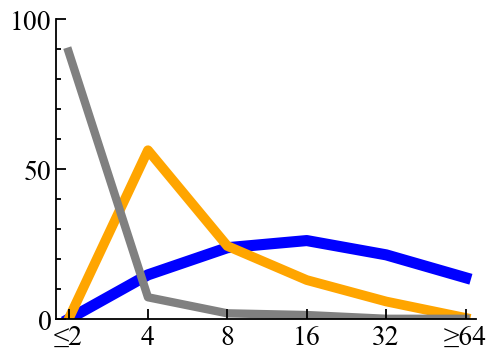

In [48]:
def plotFC_hist_from_df(df, groups, group_names, days, 
                        group_linewidths=[8, 7, 6], major_tick_length=7, minor_tick_length=3.5, 
                        x_ticks=None, tick_width=1.3, figsize=(6, 4), 
                        colors=['blue', 'orange', 'gray'], labelsize=20, 
                        custom_bins=[1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256], 
                        ylim=55, saveFigure=False, filename=None, 
                        use_proxy_days=False, return_matching_ratios=False, target_ratio=None):

    from fractions import Fraction
    from matplotlib.ticker import LogLocator, MultipleLocator

    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

    # Full set of bins
    bins = [1/1024, 1/512, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]

    group_ratios = {}
    start_tick = x_ticks[0]
    end_tick = x_ticks[-1]

    for i, group in enumerate(groups):
        ratios = []
        group_serums = []

        for serum in group:
            subj_df = df[df['Subject'] == serum]

            virus = subj_df['Vaccine Strain'].iloc[0]  # assumes one vax strain per subject
            use_day_col = 'Proxy Day' if use_proxy_days else 'Day'

            try:
                day1_value = subj_df[(subj_df['Virus'] == virus) & (subj_df[use_day_col] == days[0])]['Fold-change'].values[0]
                day2_value = subj_df[(subj_df['Virus'] == virus) & (subj_df[use_day_col] == days[1])]['Fold-change'].values[0]
            except IndexError:
                continue  # skip if any value is missing

            if day1_value is not None and day2_value is not None:
                ratios.append(day1_value / day2_value)
                group_serums.append(serum)

        if len(ratios) > 0:
            ratios = np.array(ratios)
            group_ratios[i] = {'serums': group_serums, 'ratios': ratios}

            counts, bin_edges = np.histogram(ratios, bins=bins)
            start_cumulative = counts[bin_edges[:-1] <= start_tick].sum()
            end_cumulative = counts[bin_edges[:-1] >= end_tick].sum()

            percentages = (counts / len(ratios)) * 100
            percentages[bin_edges[:-1] <= start_tick] = (start_cumulative / len(ratios)) * 100
            percentages[bin_edges[:-1] >= end_tick] = (end_cumulative / len(ratios)) * 100

            mask = (bin_edges[:-1] >= start_tick) & (bin_edges[:-1] <= end_tick)
            plot_bin_edges = bin_edges[:-1][mask]
            plot_percentages = percentages[mask]
            # Print the distribution
            print(f"\n===== {group_names[i]} =====")
            for edge, pct in zip(plot_bin_edges, plot_percentages):
                label = f"≤{Fraction(start_tick).limit_denominator()}" if edge == start_tick else (
                        f"≥{Fraction(end_tick).limit_denominator()}" if edge == end_tick else str(Fraction(edge).limit_denominator()))
                print(f"Fold-change bin {label}: {pct:.1f}%")


            ax.plot(plot_bin_edges, plot_percentages, color=colors[i],
                    linewidth=group_linewidths[i], label=group_names[i], zorder=0)

    ax.set_xscale('log')
    if x_ticks is None:
        x_ticks = [start_tick] + [x for x in bins if start_tick < x < end_tick] + [end_tick]

    x_tick_labels = [f"≤{Fraction(start_tick).limit_denominator()}" if x == start_tick 
                     else (f"≥{Fraction(end_tick).limit_denominator()}" if x == end_tick 
                           else str(Fraction(x).limit_denominator())) for x in x_ticks]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=labelsize)
    ax.set_xlim(plot_bin_edges[0] * 0.9, plot_bin_edges[-1] * 1.1)

    ax.tick_params(which='major', direction='in', labelsize=labelsize, 
                   length=major_tick_length, width=tick_width, zorder=4)
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[]))
    ax.tick_params(which='minor', bottom=False)

    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels([0, 50, 100], fontsize=labelsize)
    ax.set_ylim(0, ylim)

    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='minor', direction='in', length=minor_tick_length, zorder=4, width=tick_width)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(tick_width)
    ax.spines['left'].set_linewidth(tick_width)

    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    ax.yaxis.set_minor_formatter(plt.NullFormatter())

    if return_matching_ratios and target_ratio is not None:
        matching_serums = {}
        for group_idx, group_data in group_ratios.items():
            serums = group_data['serums']
            ratios = group_data['ratios']
            matching_indices = np.isclose(ratios, target_ratio)
            matching_serums[group_idx] = [serums[idx] for idx in range(len(ratios)) if matching_indices[idx]]

        if len(matching_serums) > 0:
            print("Matching serums for the target ratio:", target_ratio)
            for group_idx, serums in matching_serums.items():
                if len(serums) > 0:
                    print(f"{group_names[group_idx]}: {serums}")

    if saveFigure:
        plt.savefig(filename, transparent=True)

    plt.show()

plotFC_hist_from_df(df=master, 
                    groups=[durable, transient, weak], 
                    group_names=['Durable', 'Transient', 'Weak'], 
                    days=['Day28p', 'Day0'], 
                    x_ticks=[2, 4, 8, 16, 32, 64],
                    use_proxy_days=True,
                    ylim=100)



## 4C: Geomean Response 2016 Fox Nam


===== DURABLE =====
Bin (0, 0) (mid=0.0): n= 51, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 51, GM=1.29, CI=(1.15, 1.46)
Bin (7, 7) (mid=7.0): n= 51, GM=9.16, CI=(6.44, 13.59)
Bin (14, 14) (mid=14.0): n= 51, GM=21.00, CI=(15.36, 29.10)
Bin (21, 21) (mid=21.0): n= 51, GM=19.62, CI=(14.35, 26.83)
Skipping replacement for durable due to missing bin data.

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n= 21, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 21, GM=1.30, CI=(1.10, 1.59)
Bin (7, 7) (mid=7.0): n= 21, GM=5.04, CI=(3.62, 7.02)
Bin (14, 14) (mid=14.0): n= 21, GM=8.83, CI=(6.35, 12.70)
Bin (21, 21) (mid=21.0): n= 21, GM=7.01, CI=(5.38, 9.44)
Skipping replacement for transient due to missing bin data.

===== WEAK =====
Bin (0, 0) (mid=0.0): n= 25, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 25, GM=0.92, CI=(0.76, 1.12)
Bin (7, 7) (mid=7.0): n= 25, GM=1.43, CI=(1.21, 1.69)
Bin (14, 14) (mid=14.0): n= 25, GM=1.89, CI=(1.56, 2.30)
Bin (21, 21) (mid=21.0): n= 25, GM=1.39, 

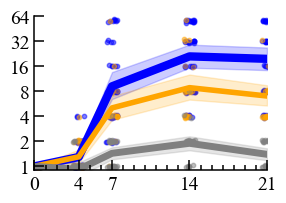

In [79]:
fox_nam_bins = ([(0,0), (4,4), (7,7), (14,14), (21,21)])
plotFC_new(master, groups=[fox_nam_durable, fox_nam_transient, fox_nam_weak], jitter_days=0.5, show_individual_responses=True, jitter_factor=0.02,clip_y=56,alpha=0.5,group_names=['durable', 'transient', 'weak'], apply_smoothing=False,linewidths =[6,4,5],major_x_ticks = [0,4,7, 14, 21], showEveryDay=True, xlimit=(0,21),ylimit=(0.9,64), figsize=(3, 2), bins = fox_nam_bins, dash_start=None, dash_end=None,)


## 4D: Geomean Repsones 2010 Henn


===== STRONG =====
Bin (0, 0) (mid=0.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (1, 1) (mid=1.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (2, 2) (mid=2.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (3, 3) (mid=3.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (5, 5) (mid=5.0): n=  7, GM=1.81, CI=(1.00, 4.00)
Bin (6, 6) (mid=6.0): n=  7, GM=3.62, CI=(1.22, 13.13)
Bin (7, 7) (mid=7.0): n=  7, GM=5.38, CI=(1.81, 19.50)
Bin (8, 8) (mid=8.0): n=  7, GM=10.77, CI=(4.88, 28.98)
Bin (9, 9) (mid=9.0): n=  7, GM=8.00, CI=(3.28, 23.78)
Bin (10, 10) (mid=10.0): n=  7, GM=17.67, CI=(8.00, 43.07)
Bin (21, 21) (mid=21.0): n=  7, GM=14.49, CI=(5.94, 35.33)

===== WEAK =====
Bin (0, 0) (mid=0.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (1, 1) (mid=1.0): n=  7, GM=0.91, CI=(0.74, 1.00)
Bin (2, 2) (mid=2.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (3, 3) (mid=3.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (5, 5) (mid=5.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (6, 6) (mid=6.0): n=  7, GM=1.00, CI=(1.00, 1.00)
Bin (7, 7) (mid=7.0): n=  7, 

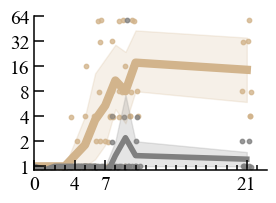

In [91]:
henn_bins = ([(0,0), (1,1), (2,2), (3,3), (5,5),(6,6), (7,7), (8,8), (9,9), (10,10), (21,21)])
plotFC_new(master,
           groups=[henn_strong, henn_weak], 
           group_names=['strong', 'weak'],
           colors = ['tan', 'gray'], 
           apply_smoothing=False,
           linewidths =[6,4,5],
           major_x_ticks = [0,4,7, 21], 
           showEveryDay=True, 
           xlimit=(0,23),
           ylimit=(0.9,64), 
           figsize=(3, 2), 
           bins = henn_bins,
           show_individual_responses=True,
           jitter_factor=0.009, 
           dash_start=None, dash_end=None,
           clip_y=57,
           jitter_days=0.5)

## 4E: Geomean Response 2010 Kennedy


===== STRONG =====
Bin (0, 0) (mid=0.0): n=100, GM=1.00, CI=(1.00, 1.00)
Bin (28, 28) (mid=28.0): n=100, GM=8.57, CI=(7.41, 9.99)
Bin (75, 75) (mid=75.0): n=100, GM=7.16, CI=(5.98, 8.51)

===== WEAK =====
Bin (0, 0) (mid=0.0): n= 59, GM=1.00, CI=(1.00, 1.00)
Bin (28, 28) (mid=28.0): n= 59, GM=1.15, CI=(0.97, 1.36)
Bin (75, 75) (mid=75.0): n= 59, GM=1.41, CI=(1.15, 1.78)


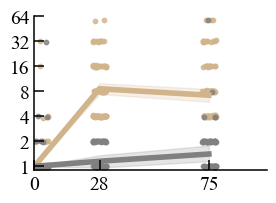

In [103]:
kennedy_2010 = master[master['Dataset'] == '2010 Kennedy'].copy()
# split into weak and strong based solely on vaccine strain at day 21
kennedy_2010_strong = kennedy_2010[(kennedy_2010['Day']==28)&
                   (kennedy_2010['Fold-change']>=4)].Subject.unique().tolist()
kennedy_2010_weak = kennedy_2010[(kennedy_2010['Day']==28)& 
                     (kennedy_2010['Fold-change']<4)].Subject.unique().tolist()
kennedy_2010_bins = ([(0,0), (28,28), (75,75)])
plotFC_new(master, groups=[kennedy_2010_strong, kennedy_2010_weak], 
           group_names=['strong', 'weak'],
           colors = ['tan', 'gray'], 
           apply_smoothing=False,
           linewidths =[4,4],
           major_x_ticks = [0,28,75], 
           showEveryDay=False, 
           xlimit=(0,100),
           ylimit=(0.9,64), 
           figsize=(3, 2), 
           bins = kennedy_2010_bins,
           show_individual_responses=True,
           jitter_factor=0.01, 
           dash_start=None, dash_end=None,
           clip_y=57,
           jitter_days=3)

## 4F: Geomean Response for 2022 UGA


===== WEAK =====
Bin (0, 0) (mid=0.0): n= 98, GM=1.00, CI=(1.00, 1.00)
Bin (14, 40) (mid=27.0): n= 96, GM=2.20, CI=(1.89, 2.58)
Bin (75, 100) (mid=87.5): n= 78, GM=1.55, CI=(1.32, 1.83)

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n= 47, GM=1.00, CI=(1.00, 1.00)
Bin (14, 40) (mid=27.0): n= 46, GM=11.31, CI=(8.37, 16.24)
Bin (75, 100) (mid=87.5): n= 42, GM=4.49, CI=(3.28, 6.05)
Skipping replacement for transient due to missing bin data.

===== DURABLE =====
Bin (0, 0) (mid=0.0): n= 23, GM=1.00, CI=(1.00, 1.00)
Bin (14, 40) (mid=27.0): n= 23, GM=32.98, CI=(22.97, 48.80)
Bin (75, 100) (mid=87.5): n= 19, GM=16.59, CI=(11.95, 23.90)
Skipping replacement for durable due to missing bin data.


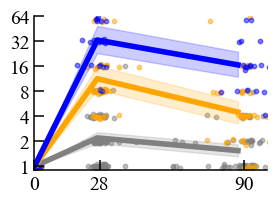

In [39]:
try:
    _ = master_uga2022
    uga2022_bins = [(0,0), (14,40), (75, 100)]
    plotFC_new(master_uga2022, groups=[weak_uga2022, transient_uga2022, durable_uga2022], 
            group_names=['weak', 'transient', 'durable'],
            colors = ['gray', 'orange', 'blue'], 
            apply_smoothing=False,
            linewidths =[4,4, 4],
            major_x_ticks = [0,28,90], 
            showEveryDay=False, 
            xlimit=(0,100),
            ylimit=(0.9,64), 
            figsize=(3, 2), 
            bins = uga2022_bins,
            show_individual_responses=True,
            jitter_factor=0.03, 
            dash_start=None, dash_end=None,
            clip_y=57,jitter_days=3, alpha =0.5)
except:
    print("2022 UGA not loaded because it is not yet publically available.")


# Figure 5

## 5A: Geomean Long-term Response


===== DURABLE =====
Bin (0, 0) (mid=0.0): n=210, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 51, GM=2.56, CI=(1.99, 3.35)
Bin (7, 7) (mid=7.0): n= 51, GM=9.83, CI=(7.04, 14.05)
Bin (14, 14) (mid=14.0): n= 51, GM=18.11, CI=(13.42, 25.30)
Bin (21, 21) (mid=21.0): n=106, GM=16.69, CI=(13.42, 21.06)
Bin (22, 75) (mid=48.5): n=104, GM=16.87, CI=(14.19, 20.29)
Bin (76, 120) (mid=75.0): n=104, GM=16.87, CI=(14.19, 20.29)
Bin (180, 250) (mid=98.0): n=  0, GM=nan, CI=(nan, nan)
Bin (251, 300) (mid=215.0): n= 13, GM=6.14, CI=(4.66, 8.87)
Bin (301, 350) (mid=275.5): n= 86, GM=6.92, CI=(5.88, 8.45)
Bin (351, 500) (mid=325.5): n= 57, GM=6.41, CI=(5.59, 7.47)
Bin (extended point) (mid=425.5): n= 54, GM=6.90, CI=(5.82, 8.37)

===== TRANSIENT =====
Bin (0, 0) (mid=0.0): n=238, GM=1.00, CI=(1.00, 1.00)
Bin (4, 4) (mid=4.0): n= 21, GM=1.87, CI=(1.48, 2.43)
Bin (7, 7) (mid=7.0): n= 21, GM=5.05, CI=(3.65, 7.21)
Bin (14, 14) (mid=14.0): n= 21, GM=7.75, CI=(5.74, 10.84)
Bin (21, 21) (mid=21.0): n= 71

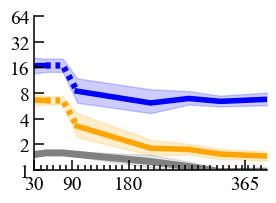

In [45]:
bins = [(21,21), (22, 75), (76, 120), (180, 250), (251, 300), (301, 350), (351, 500)] 
bins = [(0, 0), (4, 4), (7, 7), (14, 14), (21, 21), (22, 75), (76, 120), (180, 250), (251, 300), (301, 350), (351, 500)] 
major_x_ticks = [30, 90, 180, 365]
ylimit = (4, 64)
xlimit = (30, 400)

try:
    _=durable_uga2022
    replacement_groups = [durable_uga2022, transient_uga2022]
    replacement_bin = (76,120)
    dash_start=6
    dash_end=7
    df = pd.concat([master, master_uga2022], ignore_index=True)
    
except:
    replacement_groups = None
    replacement_bin = None
    dash_start=6
    dash_end=6
    df=master




fold_change = True


plotFC_new(df, groups=[durable, transient, weak], empty = False, group_names=['durable', 'transient', 'weak'],
           bins=bins, replacement_groups=replacement_groups, replacement_bin=replacement_bin, apply_smoothing=True, 
           extend_to_day_75=True, dash_start = dash_start, showEveryDay = 10, clip_y=57, linewidths=[4, 4, 5], clip_x=None, alpha = 0.2, jitter_factor = 0.045, labelsize = 14, show_individual_responses = False, fold_change = fold_change, xlimit = (30,400),colors = ['blue', 'orange', 'gray'], ylimit = ylimit, dash_end = dash_end,  major_x_ticks = major_x_ticks, saveFigure = False,  dashed_groups = ['durable', 'transient'], figsize=(3, 2))

## 5B: Distribution of FC at Day365


===== Durable =====
Fold-change bin ≤1: 0.0%
Fold-change bin 2: 0.0%
Fold-change bin 4: 50.5%
Fold-change bin ≥8: 49.5%

===== Transient =====
Fold-change bin ≤1: 42.4%
Fold-change bin 2: 49.2%
Fold-change bin 4: 7.1%
Fold-change bin ≥8: 1.3%

===== Weak =====
Fold-change bin ≤1: 73.5%
Fold-change bin 2: 20.5%
Fold-change bin 4: 4.0%
Fold-change bin ≥8: 2.1%


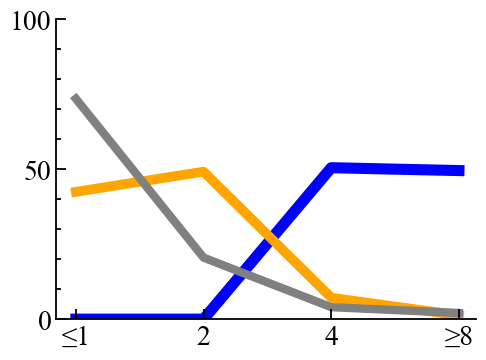

In [49]:
plotFC_hist_from_df(df=master, 
                    groups=[durable, transient, weak], 
                    group_names=['Durable', 'Transient', 'Weak'], 
                    days=['Day365p', 'Day0'], 
                    x_ticks=[1, 2, 4, 8],
                    use_proxy_days=True,
                    ylim=100)

## 5C: Distribution of Day365 HAI / Day28 HAI


===== Durable =====
Fold-change bin ≤1/8: 14.8%
Fold-change bin 1/4: 21.9%
Fold-change bin 1/2: 37.6%
Fold-change bin ≥1: 25.7%

===== Transient =====
Fold-change bin ≤1/8: 32.8%
Fold-change bin 1/4: 37.4%
Fold-change bin 1/2: 26.9%
Fold-change bin ≥1: 2.9%

===== Weak =====
Fold-change bin ≤1/8: 4.4%
Fold-change bin 1/4: 15.5%
Fold-change bin 1/2: 33.8%
Fold-change bin ≥1: 46.2%


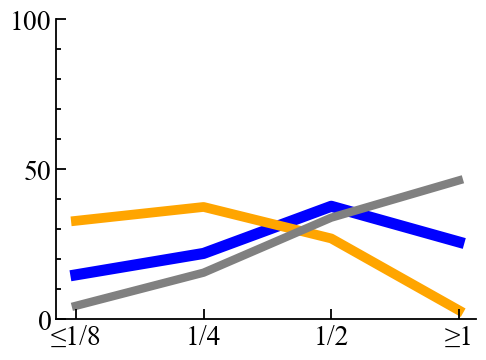

In [52]:
plotFC_hist_from_df(df=master, 
                    groups=[durable, transient, weak], 
                    group_names=['Durable', 'Transient', 'Weak'], 
                    days=['Day365p', 'Day28p'], 
                    x_ticks=[1/8, 1/4, 1/2, 1],
                    use_proxy_days=True,
                    ylim=100)

# Figure 6

In [53]:
def prediction_rules (known_timepoint, target_timepoint, known_value) :
    
    ## for known_timepoint day 7 ##
    if known_timepoint in [7,8] :
        # for target_timepoint = day 0
        if target_timepoint == 0 :
            target_pred = 1
            return target_pred
        # for target_timepint = day 4 but others for henn
        if target_timepoint > 0 and target_timepoint < 7 :
            target_pred = 1
            return target_pred
        # for target_timepoint = day 7 (known)
        if target_timepoint in [7,8] :
            target_pred = known_value
            return target_pred
        # for target_timepoints in peak plateau
        if target_timepoint >= 14 and target_timepoint <= 75 :
            if known_value >= 4 : # if likely durable or transient 
                target_pred = known_value * 2 # doubles for durable or transient
            elif known_value < 4 : # if likely weak
                target_pred =  known_value
            return target_pred
        # for target_timepoints around day 90
        if target_timepoint > 75 and target_timepoint < 180 :
            if known_value >= 4 : # if likely durable or transient
                target_pred = known_value # day90 is equal to day 7 b/c it goes up 2x then down 2x by d90
            elif known_value < 4 :
                target_pred = known_value
            return target_pred
        # for target_timepoints greater than day 100 (long-term)
        if target_timepoint >= 180 :
            if known_value >= 8 : # if likely durable 
                target_pred = known_value # day 90 = long term for durable
            elif known_value >= 4 : # if likely transient
                target_pred = known_value / 2
            elif known_value < 4 : # likely weak
                target_pred = 1
            # else : # likely weak
            #     target_pred = 1
            return target_pred
            
    
    
    ## for known_timepoint in peak plateau ##
    if known_timepoint >= 14 and known_timepoint <= 75 :
        # for target_timepoint = day0 
        if target_timepoint == 0 :
            target_pred = 1
            return target_pred
        # for target_timepoint = day 4 (assuming day 4 is always 0) but also others for henn
        if target_timepoint > 0 and target_timepoint < 7 :
            target_pred = 1
            return target_pred
        # for target_timepoint = day 7 (assuming day 7 is always 0 for now) (probably if transient or durable, just double d7 to get peak plateau)
        if target_timepoint in [7,8] :
            if known_value >= 4 : # if likley transient or durable
                target_pred = known_value / 2
            else : # if likely weak
                target_pred = known_value
            return target_pred
        # for target_timepoint in peak plateau (assuming it goes from day 14 to day 75)
        if target_timepoint >= 14 and target_timepoint <=75 :
            target_pred = known_value
            return target_pred
        # for target_timepoint around day 90
        elif target_timepoint > 75 and target_timepoint < 180 :
            if known_value >= 16 : # if big peak plateau likely durable
                target_pred = known_value / 2
            elif known_value >= 4 : # if medium peak plateau likely transient
                target_pred = known_value / 2
            elif known_value < 4 : # if small peak plateau likely weak
                target_pred = known_value 
            return target_pred
        # for target_timepoint greater than day 100 (long-term)
        elif target_timepoint >= 180 :
            if known_value >= 16 : # if big plateau likely durable
                target_pred = known_value / 2
            elif known_value >= 4 : # if medium peak plateau likely transient
                target_pred = known_value / 4
            elif known_value < 4 : # if small peak plateau likely weak
                target_pred = known_value / 2
            return target_pred         

## 6B: 2018 Sergeeva Preds (Known Day7)

In [120]:
#
# Generate predictions from a known timepoint to target timepoints
#

def generate_predictions(df, dataset_filter, known_day, target_days):
    # Filter dataset
    subset = df[df['Dataset'].str.contains(dataset_filter)].copy()

    # Initialize results DataFrame
    result = pd.DataFrame()

    for sub in subset['Subject'].unique():
        # Extract the known fold-change value
        known_values = subset[(subset['Subject'] == sub) & (subset['Day'] == known_day)]['Fold-change'].values
        if len(known_values) == 0:
            continue  # Skip if known day value is missing

        known_fc = known_values[0]
        sub_preds = {'Subject': sub, f'Known Day {known_day} FC': known_fc}

        # Generate predictions for each target day
        for target_day in target_days:
            sub_preds[f'Day {target_day} Predicted FC'] = prediction_rules(known_day, target_day, known_fc)

        # Add this serum's predictions to the result DataFrame
        result = pd.concat([result, pd.DataFrame([sub_preds])], ignore_index=True)

    return result

#
# Example: Generate predictions using Day 7 and Day 21 as known timepoints
#

sergeeva_known_day_7_preds = generate_predictions(
    df=master,
    dataset_filter='Sergeeva',
    known_day=7,
    target_days=[21, 90, 180, 365]
)




def compute_rmse_fold_change(preds_df, df):
    fold_errors = []

    for _, row in preds_df.iterrows():
        subject = row['Subject']
        for col in preds_df.columns:
            if col.startswith('Day') and 'Predicted FC' in col:
                # Extract target day from column name
                target_day = int(col.split()[1])
                predicted = row[col]

                actual_values = df[(df['Subject'] == subject) & (df['Day'] == target_day)]['Fold-change'].values
                if len(actual_values) == 0 or predicted is None:
                    continue

                actual = actual_values[0]

                # Compute fold error
                if actual > 0 and predicted > 0:
                    fold_error = max(predicted / actual, actual / predicted)
                    fold_errors.append(np.log2(fold_error) ** 2)

    if not fold_errors:
        return np.nan

    rmse_log2 = np.sqrt(np.mean(fold_errors))
    return 2 ** rmse_log2  # convert back to fold-change units

rmse_fc_day7 = compute_rmse_fold_change(sergeeva_known_day_7_preds, sergeeva)


print(f"Fold-change RMSE using Day 7 as known: {rmse_fc_day7:.1f}x")


Fold-change RMSE using Day 7 as known: 3.2x


In [ ]:
def add_actual_fold_changes(preds_df, df):
    # Make a copy so we don't overwrite the original
    preds_df = preds_df.copy()

    for col in preds_df.columns:
        if col.startswith('Day') and 'Predicted FC' in col:
            target_day = int(col.split()[1])
            actual_col = f'Day {target_day} Actual FC'

            # Initialize column with None
            preds_df[actual_col] = None

            # Fill in actual fold-change values
            for idx, row in preds_df.iterrows():
                subject = row['Subject']
                actual_values = df[(df['Subject'] == subject) & (df['Day'] == target_day)]['Fold-change'].values
                if len(actual_values) > 0:
                    preds_df.at[idx, actual_col] = actual_values[0]

    return preds_df

sergeeva_known_day_7_preds_with_actuals = add_actual_fold_changes(sergeeva_known_day_7_preds, sergeeva)




In [98]:
sergeeva_strong_month = sergeeva[(sergeeva['Proxy Day']=='Day28p')&
                                (sergeeva['Fold-change']>=4)].Subject.unique().tolist()
sergeeva_strong_year = sergeeva[(sergeeva['Proxy Day']=='Day365p')&
                                (sergeeva['Fold-change']>=4)].Subject.unique().tolist()

sergeeva_weak_month = sergeeva[(sergeeva['Proxy Day']=='Day28p')&
                                (sergeeva['Fold-change']<4)].Subject.unique().tolist()

sergeeva_durable = list(set(sergeeva_strong_month).intersection(set(sergeeva_strong_year)))
sergeeva_transient = list(set(sergeeva_strong_month).difference(set(sergeeva_strong_year)))
sergeeva_weak = sergeeva_weak_month

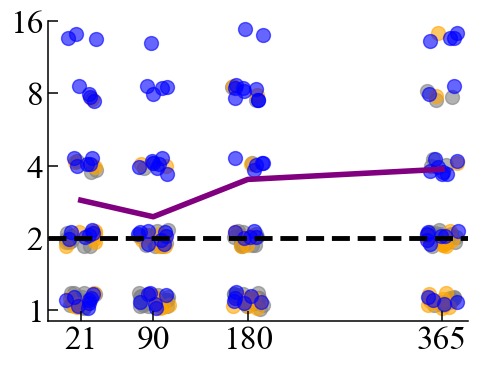

In [118]:

from matplotlib.ticker import FixedFormatter, FixedLocator
from sklearn.metrics import mean_squared_error

def plot_sergeeva_error (sergeeva_preds_with_actuals):

    # === Step 1: Add group info ===
    subject_to_group = {s: 'durable' for s in sergeeva_durable}
    subject_to_group.update({s: 'transient' for s in sergeeva_transient})
    subject_to_group.update({s: 'weak' for s in sergeeva_weak})

    # === Step 2: Melt prediction DataFrame to long format ===
    long_df = pd.wide_to_long(
        sergeeva_preds_with_actuals,
        stubnames=['Day'],
        i='Subject',
        j='Target',
        sep=' ',
        suffix=r'\d+',
        # Filter only FC columns (Predicted + Actual)
    ).reset_index()

    # Keep only predicted/actual FC columns
    pred_cols = [col for col in sergeeva_preds_with_actuals.columns if 'Predicted FC' in col]
    actual_cols = [col for col in sergeeva_preds_with_actuals.columns if 'Actual FC' in col]

    # Manual reshaping
    melted = []
    for col in pred_cols:
        day = int(col.split()[1])
        actual_col = col.replace('Predicted', 'Actual')
        for _, row in sergeeva_preds_with_actuals.iterrows():
            if pd.notna(row[col]) and pd.notna(row[actual_col]):
                melted.append({
                    'Subject': row['Subject'],
                    'Day': day,
                    'Predicted_FC': row[col],
                    'Actual_FC': row[actual_col],
                    'Group': subject_to_group.get(row['Subject'], None)
                })
    melted_df = pd.DataFrame(melted)

    # === Step 3: Calculate log2 RMSE ===
    melted_df['Log2_Predicted_FC'] = np.log2(melted_df['Predicted_FC'])
    melted_df['Log2_Actual_FC'] = np.log2(melted_df['Actual_FC'])
    melted_df['Log2_Error_Sq'] = (melted_df['Log2_Predicted_FC'] - melted_df['Log2_Actual_FC']) ** 2
    melted_df['FC_RMSE'] = 2 ** np.sqrt(melted_df['Log2_Error_Sq'])

    # Clip to avoid extreme values in visualization
    melted_df['FC_RMSE_Clipped'] = melted_df['FC_RMSE'].clip(lower=1.1, upper=14)

    # === Step 4: Overall RMSE per day ===
    overall_rmse = melted_df.groupby('Day').apply(
        lambda g: 2 ** np.sqrt(mean_squared_error(g['Log2_Actual_FC'], g['Log2_Predicted_FC']))
    ).reset_index(name='RMSE')

    # === Step 5: Plotting ===
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

    # Colors
    group_colors = {
        'durable': 'blue',
        'transient': 'orange',
        'weak': 'gray'
    }

    # Add jittered individual points
    np.random.seed(42)
    for group in ['weak', 'transient', 'durable']:
        group_data = melted_df[melted_df['Group'] == group]
        if group_data.empty:
            continue
        days_jittered = group_data['Day'] + np.random.uniform(-15, 15, size=len(group_data))
        rmse_jittered = group_data['FC_RMSE_Clipped'] * (1 + np.random.uniform(-0.08, 0.08, size=len(group_data)))

        ax.scatter(
            days_jittered,
            rmse_jittered,
            alpha=0.6,
            s=100,
            label=f'{group.capitalize()} (Individual)',
            color=group_colors[group],
            zorder=2
        )

    # Add overall RMSE line
    ax.plot(
        overall_rmse['Day'],
        overall_rmse['RMSE'],
        label='Overall (All Groups)',
        color='purple',
        linewidth=4,
        zorder=8
    )

    # Reference line at 2x error
    ax.axhline(y=2, color='black', linestyle='--', linewidth=3.5)


    # Axis formatting
    ax.set_xlim(-10, 390)
    ax.set_ylim(0.9, 16)
    ax.set_yscale('log')
    ax.set_yticks([1, 2, 4, 8, 16])
    ax.set_yticklabels(['1', '2', '4', '8', '16'])
    ax.set_xticks(sorted(overall_rmse['Day'].unique()))
    ax.tick_params(which='major', direction='in', length=7, width=1.1, labelsize=24, zorder=10)
    ax.get_yaxis().set_major_formatter(FixedFormatter(['1', '2', '4', '8', '16']))
    ax.get_yaxis().set_major_locator(FixedLocator([1, 2, 4, 8, 16]))
    ax.get_yaxis().set_tick_params(which='minor', left=False, right=False)

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)
    ax.spines['bottom'].set_linewidth(1.1)
    ax.xaxis.set_zorder(20)
    ax.yaxis.set_zorder(20)




    plt.show()

plot_sergeeva_error(sergeeva_known_day_7_preds_with_actuals)


## 6C: 2018 Sergeeva Preds (Known Day21)

Fold-change RMSE using Day 21 as known: 2.2x


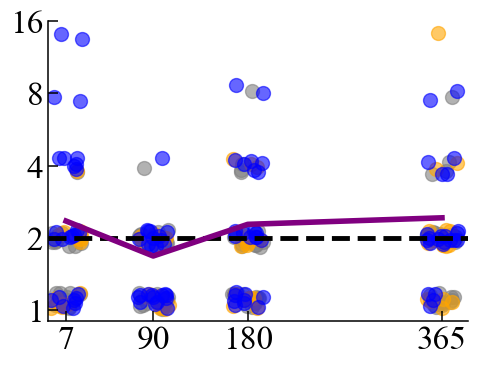

In [124]:
sergeeva_known_day_21_preds = generate_predictions(
    df=master,
    dataset_filter='Sergeeva',
    known_day=21,
    target_days=[7, 90, 180, 365]
)
sergeeva_known_day_21_preds_with_actuals = add_actual_fold_changes(sergeeva_known_day_21_preds, sergeeva)

rmse_fc_day21 = compute_rmse_fold_change(sergeeva_known_day_21_preds, sergeeva)
print(f"Fold-change RMSE using Day 21 as known: {rmse_fc_day21:.1f}x")
plot_sergeeva_error(sergeeva_known_day_21_preds_with_actuals)

## 6D: 2018 Kennedy Preds (Known Day8)

In [140]:
kennedy_subs_with_na = kennedy_2018[kennedy_2018['HAI'].isna()].Subject.unique()
kennedy_2018_valid = kennedy_2018[~kennedy_2018['Subject'].isin(kennedy_subs_with_na)]

kennedy_2018_known_day_8_preds = generate_predictions(
    df=kennedy_2018_valid,
    dataset_filter='2018 Kennedy',
    known_day=8,
    target_days=[28]
)

rmse_fc_day8 = compute_rmse_fold_change(kennedy_2018_known_day_8_preds, kennedy_2018_valid)

print(f"Fold-change RMSE using Day 8 as known: {rmse_fc_day8:.1f}x")

Fold-change RMSE using Day 8 as known: 1.7x


In [143]:
def add_actual_fold_changes(preds_df, df):
    # Make a copy so we don't overwrite the original
    preds_df = preds_df.copy()

    for col in preds_df.columns:
        if col.startswith('Day') and 'Predicted FC' in col:
            target_day = int(col.split()[1])
            actual_col = f'Day {target_day} Actual FC'

            # Initialize column with None
            preds_df[actual_col] = None

            # Fill in actual fold-change values
            for idx, row in preds_df.iterrows():
                subject = row['Subject']
                actual_values = df[(df['Subject'] == subject) & (df['Day'] == target_day)]['Fold-change'].values
                if len(actual_values) > 0:
                    preds_df.at[idx, actual_col] = actual_values[0]

    return preds_df

kennedy_2018_known_day_8_preds_with_actuals = add_actual_fold_changes(kennedy_2018_known_day_8_preds, kennedy_2018_valid)




In [144]:
kennedy_2018_strong = kennedy_2018_valid[(kennedy_2018_valid['Day']==28)&
                                (kennedy_2018_valid['Fold-change']>=4)]['Subject'].unique().tolist()
kennedy_2018_weak = kennedy_2018_valid[(kennedy_2018_valid['Day']==28)&
                                (kennedy_2018_valid['Fold-change']<4)]['Subject'].unique().tolist()

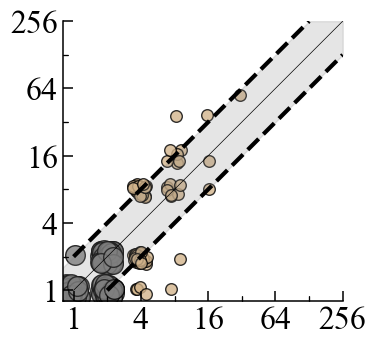

In [149]:
def plot_pred_vs_meas(groups, colors, sizes, prediction_results,
                      predicted_col, actual_col,
                      saveFigure=False, filename=None):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

    for i, group in enumerate(groups):
        group_results = prediction_results[prediction_results['Subject'].isin(group)].copy()
        actuals = group_results[actual_col] * (1 + np.random.uniform(-0.15, 0.15, size=len(group_results)))
        preds = group_results[predicted_col] * (1 + np.random.uniform(-0.15, 0.15, size=len(group_results)))
        ax.scatter(actuals, preds, color=colors[i], s=sizes[i], alpha=0.8, edgecolor='black')

    # Identity line and bounds
    ax.plot([2, 256], [1, 128], color='black', linestyle='--', linewidth=3, label='y=0.5x')
    ax.plot([1, 128], [2, 256], color='black', linestyle='--', linewidth=3, label='y=2x')
    ax.plot([1, 256], [1, 256], color='black', linestyle='-', linewidth=0.5, label='y=x')

    # Fill between bounds
    x_dense_full = np.logspace(np.log10(0.7), np.log10(256), 500)
    y_upper_full = np.clip(2 * x_dense_full, 0.7, 256)
    y_lower_full = np.clip(0.5 * x_dense_full, 0.7, 256)
    ax.fill_between(x_dense_full, y_upper_full, y_lower_full, color='gray', alpha=0.2)

    # Axes ticks and labels
    ticks = [1, 4, 16, 64, 256]
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.set_yticklabels([str(t) for t in ticks])
    ax.set_xticklabels([str(t) for t in ticks])
    ax.tick_params(which='major', direction='in', length=7, width=1.1, labelsize=23)

    # Minor ticks
    ax.yaxis.set_minor_locator(plt.LogLocator(base=2.0, subs=[1.0, 2.0, 4.0], numticks=10))
    ax.xaxis.set_minor_locator(plt.LogLocator(base=2.0, subs=[1.0, 2.0, 4.0], numticks=10))
    ax.tick_params(which='minor', length=3.5, width=0.8, direction='in', labelsize=0)

    # Axis limits and styling
    ax.set_ylim(0.8, 256)
    ax.set_xlim(0.8, 256)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)
    ax.spines['bottom'].set_linewidth(1.1)
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    ax.yaxis.set_minor_formatter(plt.NullFormatter())
    ax.xaxis.set_zorder(20)
    ax.yaxis.set_zorder(20)

    if saveFigure and filename:
        plt.savefig(filename, transparent=True, dpi=300)


plot_pred_vs_meas(
    groups=[kennedy_2018_weak, kennedy_2018_strong],
    colors=['gray', 'tan'],
    sizes=[200, 70],
    prediction_results=kennedy_2018_known_day_8_preds_with_actuals,
    predicted_col='Day 28 Predicted FC',
    actual_col='Day 28 Actual FC'
)


## 6E: 2018 Kennedy Preds (Known Day28)

In [142]:
kennedy_2018_known_day_28_preds = generate_predictions(
    df=kennedy_2018_valid,
    dataset_filter='2018 Kennedy',
    known_day=28,
    target_days=[8]
)

rmse_fc_day28 = compute_rmse_fold_change(kennedy_2018_known_day_28_preds, kennedy_2018_valid)

print(f"Fold-change RMSE using Day 28 as known: {rmse_fc_day28:.1f}x")

Fold-change RMSE using Day 28 as known: 1.5x


In [150]:
kennedy_2018_known_day_28_preds_with_actuals = add_actual_fold_changes(kennedy_2018_known_day_28_preds, kennedy_2018_valid)

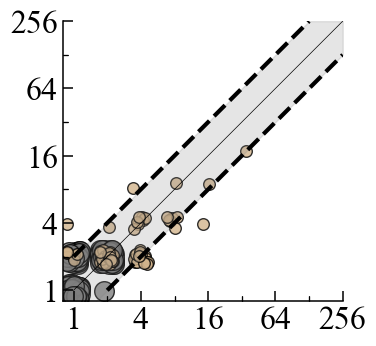

In [151]:
plot_pred_vs_meas(
    groups=[kennedy_2018_weak, kennedy_2018_strong],
    colors=['gray', 'tan'],
    sizes=[200, 70],
    prediction_results=kennedy_2018_known_day_28_preds_with_actuals,
    predicted_col='Day 8 Predicted FC',
    actual_col='Day 8 Actual FC'
)